# Research Project 



#### Finding data
- BTC price from API? or from different sources
- Oil, Gold, S&P 500 from Yahoo/Crsp/FactSet?
- Google trend - we can find google trend also through api --> pytrends: https://pypi.org/project/pytrends/
- Inflation, Interest rate in the US - CRSP or some other webpage with reliable info
+ Deciding whether we will use returns/ prices/ so on :)

In [1]:
#pip install pandas-datareader

In [2]:
import pandas_datareader.data as web
import pandas as pd
import datetime as dt
from datetime import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.formula.api import ols
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from sklearn.preprocessing import StandardScaler

### Factor 1, 2 + 3
Gold, Oil, S&P500

In [3]:
#Import yahoo finance data: Gold, SP500, Oil
yahoofin_prices = web.DataReader(['GC=F', 'CL=F', '^GSPC'], 'yahoo', start='2019-12-31', end='2022-01-18')["Adj Close"]
yahoofin_prices.rename(columns={'GC=F': 'GOLD', 'CL=F': 'OIL', '^GSPC': 'SP500'}, inplace=True)

In [4]:
#Print Gold, Oil, SP500 prices
yahoofin_prices.head()

Symbols,GOLD,OIL,SP500
Date,,,
2019-12-31,1519.500000,61.060001,3230.780029
2020-01-02,1524.500000,61.180000,3257.850098
2020-01-03,1549.199951,63.049999,3234.850098
2020-01-06,1566.199951,63.270000,3246.280029
2020-01-07,1571.800049,62.700001,3237.179932


In [5]:
#Info of Gold, Oil, SP500 prices
yahoofin_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 518 entries, 2019-12-31 to 2022-01-18
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GOLD    518 non-null    float64
 1   OIL     518 non-null    float64
 2   SP500   517 non-null    float64
dtypes: float64(3)
memory usage: 16.2 KB


In [6]:
#Calculate the returns of the prices
yahoofin_returns = yahoofin_prices.copy()
for i in range(1,len(yahoofin_prices+1)):
    yahoofin_returns.iloc[i] = np.log(yahoofin_prices.iloc[i]/yahoofin_prices.iloc[i-1])
yahoofin_returns = yahoofin_returns[1:]

C:\Users\mezyn\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
#Print Gold, Oil, SP500 returns
yahoofin_returns.head()

Symbols,GOLD,OIL,SP500
Date,,,
2020-01-02,0.003285,0.001963,0.008344
2020-01-03,0.016072,0.030108,-0.007085
2020-01-06,0.010914,0.003483,0.003527
2020-01-07,0.003569,-0.009050,-0.002807
2020-01-08,-0.009204,-0.050538,0.004890


### Factor 4
Effective Federal Funds Rate

In [8]:
#Import Effective federal funds rate (https://fred.stlouisfed.org/series/EFFR) 
interestrate = web.DataReader(['EFFR'], 'fred', start='2020-01-01', end='2022-01-01')
interestrate.rename(columns={'EFFR': 'IR'}, inplace=True)
interestrate['IR']=interestrate['IR']/100

In [9]:
#Merge first 4 factors
yahoofin_IR = yahoofin_prices.merge(interestrate, how= 'left', left_index = True, right_index = True)

In [10]:
#Print head
yahoofin_IR.head()

,GOLD,OIL,SP500,IR
Date,,,,
2019-12-31,1519.500000,61.060001,3230.780029,NaN
2020-01-02,1524.500000,61.180000,3257.850098,0.0155
2020-01-03,1549.199951,63.049999,3234.850098,0.0155
2020-01-06,1566.199951,63.270000,3246.280029,0.0155
2020-01-07,1571.800049,62.700001,3237.179932,0.0155


In [11]:
# df3 = web.DataReader(['CPIAUCSL'], 'fred', start='2019-11-30', end='2022-01-01')
# df3.rename(columns={'CPIAUCSL': 'INFL'}, inplace=True)

In [12]:
# infl = df3.copy()
# for i in range(1,len(df3+1)):
#     infl.iloc[i] = np.log(df3.iloc[i]/df3.iloc[i-1])
# infl = infl[1:]
# infl.head()

------------------------------------------------------------------------------------------------------------------

#### Other possible factors

### Factor 5 + 6
US daily News Index + Bitcoin Transactions

In [13]:
# US Daily News Index (http://www.policyuncertainty.com/us_monthly.html)
daily_news = pd.read_csv('data/All_Daily_Policy_Data.csv')
daily_news['date'] = pd.to_datetime(dict(year=daily_news.year, month=daily_news.month, day=daily_news.day))
daily_news.set_index('date', inplace = True)
daily_news = pd.DataFrame(daily_news.daily_policy_index)
daily_news = daily_news.loc['2019-12-31':]
daily_news.rename(columns = {'daily_policy_index': 'EPU'}, inplace=True)

In [14]:
# The number of daily confirmed Bitcoin transactions (https://data.nasdaq.com/data/BCHAIN/NTRAN-bitcoin-number-of-transactions)
transactions = pd.read_csv('data/BCHAIN-NTRAN.csv')
transactions.sort_values(by=['Date'], ascending=True, inplace=True)
transactions['Date'] = pd.to_datetime(transactions['Date'])
transactions.set_index('Date', inplace = True)
transactions = transactions.loc['2019-12-31':]
transactions.rename(columns = {'Value': 'transactions'}, inplace=True)

In [15]:
#Merge the daily Index and the Bitcoin transactions
dailynews_transactions = daily_news.merge(transactions, left_index = True, right_index = True)

In [16]:
#Print the head
dailynews_transactions.head()

,EPU,transactions
date,,
2019-12-31,105.75,293447.0
2020-01-01,186.06,251735.0
2020-01-02,139.13,295567.0
2020-01-03,108.10,316517.0
2020-01-04,212.82,287215.0


### Factor 7
VIX index

In [17]:
#The VIX Index is recognized as the world’s premier gauge of U.S. equity market volatility
# (https://www.cboe.com/tradable_products/vix/)
VIX = pd.read_csv('data/VIX_History.csv')
VIX['DATE'] = pd.to_datetime(VIX['DATE'])
VIX.set_index('DATE', inplace = True)
VIX = VIX.loc['2019-12-31':]
VIX.rename(columns = {'CLOSE': 'VIX'}, inplace=True)
VIX = pd.DataFrame(VIX.VIX)

In [18]:
#Merge the daily Index, the Bitcoin transactions and VIX
dn_trans_VIX = dailynews_transactions.merge(VIX, left_index = True, right_index = True)

In [19]:
#Print head
dn_trans_VIX.head()

,EPU,transactions,VIX
2019-12-31,105.75,293447.0,13.78
2020-01-02,139.13,295567.0,12.47
2020-01-03,108.10,316517.0,14.02
2020-01-06,147.96,299146.0,13.85
2020-01-07,103.98,344079.0,13.79


In [20]:
#Turn into Returns
dn_trans_VIX_returns = dn_trans_VIX.copy()
for i in range(1,len(dn_trans_VIX+1)):
    dn_trans_VIX_returns.iloc[i] = np.log(dn_trans_VIX.iloc[i]/dn_trans_VIX.iloc[i-1])
dn_trans_VIX_returns = dn_trans_VIX_returns[1:]

In [21]:
#Print return
dn_trans_VIX_returns.head()

,EPU,transactions,VIX
2020-01-02,0.274331,0.007199,-0.099893
2020-01-03,-0.252352,0.068481,0.117159
2020-01-06,0.313885,-0.056445,-0.012200
2020-01-07,-0.352743,0.139940,-0.004342
2020-01-08,-0.131692,-0.078760,-0.024965


### Factor 8 + 9
D_infections_volatility_tracker + DOW JONES GLOBAL_DJUSCA

In [22]:
#Import D_infections_volatility_tracker
path = os.path.join('data','D_infections_volatility_tracker.xlsx')
df_InfVol = pd.read_excel(path)
df_EMV= df_InfVol.drop(columns=['day', 'month', 'year'])
df_emv= df_EMV.set_index('date')

In [23]:
df_emv.head()

,daily_infect_emv_index
date,
2020-01-01,1.89
2020-01-02,2.84
2020-01-03,1.33
2020-01-04,0.00
2020-01-05,0.86


In [24]:
#Import DOW JONES GLOBAL_DJUSCA
path = os.path.join('data','DOW JONES GLOBAL_DJUSCA.csv')
df_DOWJ = pd.read_csv(path)
df_DOWJG= df_DOWJ[["Close", "Date"]]
df_DOWJG.rename(columns = {'Close': 'DOWJ'}, inplace=True)
df_DOWJG['Date'] = pd.to_datetime(df_DOWJG['Date'])
df_DOW=df_DOWJG.set_index('Date')
df_DOW.sort_values(by= 'Date', axis=0, ascending=True, inplace=True)
df_dow = pd.to_numeric(df_DOW['DOWJ'], errors='coerce')

C:\Users\mezyn\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-24-9316d9ac326a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_DOWJG['Date'] = pd.to_datetime(df_DOWJG['Date'])


In [25]:
df_dow.head()

Date
2020-01-02    935.13
2020-01-03    923.15
2020-01-06    922.07
2020-01-07    923.21
2020-01-08    931.08
Name: DOWJ, dtype: float64

In [26]:
df303 = dn_trans_VIX.merge(df_dow, left_index = True, right_index = True)
df404 = df303.merge(df_emv, left_index = True, right_index = True)

In [27]:
df404.head()

,EPU,transactions,VIX,DOWJ,daily_infect_emv_index
2020-01-02,139.13,295567.0,12.47,935.13,2.84
2020-01-03,108.10,316517.0,14.02,923.15,1.33
2020-01-06,147.96,299146.0,13.85,922.07,0.99
2020-01-07,103.98,344079.0,13.79,923.21,0.00
2020-01-08,91.15,318019.0,13.45,931.08,0.56


In [28]:
#Transform into returns
df_merge_returns = df303.copy()
for i in range(1,len(df303+1)):
    df_merge_returns.iloc[i] = np.log(df303.iloc[i]/df303.iloc[i-1])
df_merge_returns = df_merge_returns[1:]

In [29]:
df_all= df_merge_returns.merge(df_emv, left_index=True, right_index=True)

<AxesSubplot:>

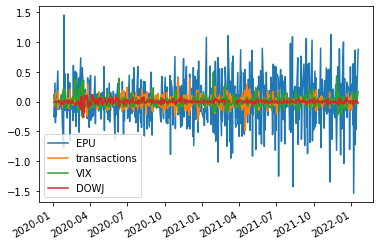

In [30]:
df_merge_returns.plot()

I think for the daily infectious diseasse tracker, we cant take log --> it will divide somethin with 0 and the result will be nan/-inf. So for that i thik its better to standardize, but for all others i think it is fine.

### Factor 10-13
Exchange rates

In [31]:
#Import Exchange rate Romania
romania = os.path.join('data','USD_RON_.csv')
df_romania = pd.read_csv(romania)
df_romania['Date'] = pd.to_datetime(df_romania['Date'])
df_romania=df_romania.set_index('Date')

#Delete the percentage sign
df_romania['Change %'] = list(map(lambda x: x[:-1], df_romania['Change %'].values))

#Rename
df_romania.rename(columns = {'Change %': 'USD_RON Change %'}, inplace=True)

In [32]:
df_romania.head()

,USD_RON Change %
Date,
2022-01-20,-0.13
2022-01-19,-0.14
2022-01-18,0.73
2022-01-17,0.07
2022-01-14,0.35


In [33]:
#Import Exchange rate India
india = os.path.join('data','USD_INR.csv')
df_india = pd.read_csv(india)
df_india['Date'] = pd.to_datetime(df_india['Date'])
df_india=df_india.set_index('Date')

#Delete the percentage sign
df_india['Change %'] = list(map(lambda x: x[:-1], df_india['Change %'].values))

#Rename
df_india.rename(columns = {'Change %': 'USD_INR Change %'}, inplace=True)

In [34]:
df_india.head()

,USD_INR Change %
Date,
2022-01-20,-0.07
2022-01-19,-0.18
2022-01-18,0.43
2022-01-17,0.12
2022-01-14,0.26


In [35]:
#Import Exchange rate kazakhstan
kazakhstan = os.path.join('data','USD_KZT_.csv')
df_kazakhstan = pd.read_csv(kazakhstan)
df_kazakhstan['Date'] = pd.to_datetime(df_kazakhstan['Date'])
df_kazakhstan=df_kazakhstan.set_index('Date')

#Delete the percentage sign
df_kazakhstan['Change %'] = list(map(lambda x: x[:-1], df_kazakhstan['Change %'].values))

#Rename
df_kazakhstan.rename(columns = {'Change %': 'USD_KZT Change %'}, inplace=True)

In [36]:
#Print head
df_kazakhstan.head()

,USD_KZT Change %
Date,
2022-01-20,-0.14
2022-01-19,0.16
2022-01-18,0.09
2022-01-17,0.03
2022-01-14,0.10


In [37]:
dfs_join= df_kazakhstan.merge(df_india,on='Date').merge(df_romania ,on='Date')
dfs_currency= dfs_join.astype(float)

### Factor 14 CRIX

In [38]:
CRIX = os.path.join('data','PerformanceGraphExport.xls')
df_CRIX = pd.read_excel(CRIX)
df_CRIX.rename(columns = {'Effective date': 'date'}, inplace=True)

In [39]:
df_CRIX

,Effective date,Royalton CRIX Crypto Index
0,2020-01-01,530.40
1,2020-01-02,509.33
2,2020-01-03,538.09
3,2020-01-06,560.83
4,2020-01-07,599.78
...,...,...
532,2022-01-14,4253.04
533,2022-01-17,4165.28
534,2022-01-18,4097.54
535,2022-01-19,4072.20


------------------------------------------------------------------------------------------------------------------

### Factor 15-16

BTC price + google trend for Bitcoin in US

In [40]:
#pip install pytrends

In [ ]:
from pytrends.request import TrendReq
from pytrends import dailydata

Bitcoin_df = dailydata.get_daily_data('Bitcoin', 2020, 1, 2022, 1, geo = 'US')

Bitcoin:2020-01-01 2020-01-31
Bitcoin:2020-02-01 2020-02-29
Bitcoin:2020-03-01 2020-03-31
Bitcoin:2020-04-01 2020-04-30
Bitcoin:2020-05-01 2020-05-31
Bitcoin:2020-06-01 2020-06-30
Bitcoin:2020-07-01 2020-07-31
Bitcoin:2020-08-01 2020-08-31
Bitcoin:2020-09-01 2020-09-30
Bitcoin:2020-10-01 2020-10-31
Bitcoin:2020-11-01 2020-11-30
Bitcoin:2020-12-01 2020-12-31
Bitcoin:2021-01-01 2021-01-31
Bitcoin:2021-02-01 2021-02-28
Bitcoin:2021-03-01 2021-03-31
Bitcoin:2021-04-01 2021-04-30
Bitcoin:2021-05-01 2021-05-31
Bitcoin:2021-06-01 2021-06-30
Bitcoin:2021-07-01 2021-07-31
Bitcoin:2021-08-01 2021-08-31


In [ ]:
Bitcoin_df

In [ ]:
path = os.path.join('data','BTC-USD-2.csv')
df_data = pd.read_csv(path)
df_data.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
df_data['Date']=pd.to_datetime(df_data['Date'])

In [ ]:
df_btc=df_data.set_index('Date')

In [ ]:
returns_btc = df_btc.copy()
for i in range(1,len(df_btc+1)):
    returns_btc.iloc[i] = np.log(df_btc.iloc[i]/df_btc.iloc[i-1])
returns_btc = returns_btc[1:]

In [ ]:
returns_btc

### Factor 17 - Bitcoin Tweets

In [ ]:
csv_data_raw = '2014-04-08, 8193\n2014-04-09, 15039\n2014-04-10, 14907\n2014-04-11, 7582\n2014-04-12, 10674\n2014-04-13, 13266\n2014-04-14, 14835\n2014-04-15, 15790\n2014-04-16, 15215\n2014-04-17, 14028\n2014-04-18, 12337\n2014-04-19, 12139\n2014-04-20, 14244\n2014-04-21, 16098\n2014-04-22, 16232\n2014-04-23, 15471\n2014-04-24, 15255\n2014-04-25, 12283\n2014-04-26, 11667\n2014-04-27, 15969\n2014-04-28, 16706\n2014-04-29, 17588\n2014-04-30, 16988\n2014-05-01, 20057\n2014-05-02, 12910\n2014-05-03, 12716\n2014-05-04, 21273\n2014-05-05, 16806\n2014-05-06, 16970\n2014-05-07, 21518\n2014-05-08, 17442\n2014-05-09, 14225\n2014-05-10, 13469\n2014-05-11, 15910\n2014-05-12, 16935\n2014-05-13, 18167\n2014-05-14, 32817\n2014-05-15, 14474\n2014-05-16, 14587\n2014-05-17, 12892\n2014-05-18, 13595\n2014-05-19, 21515\n2014-05-20, 20254\n2014-05-21, 20217\n2014-05-22, 19485\n2014-05-23, 13630\n2014-05-24, 13823\n2014-05-25, 14792\n2014-05-26, 19718\n2014-05-27, 18545\n2014-05-28, 17571\n2014-05-29, 21731\n2014-05-30, 12882\n2014-05-31, 12849\n2014-06-01, 16427\n2014-06-02, 17858\n2014-06-03, 18010\n2014-06-04, 18707\n2014-06-05, 16611\n2014-06-06, 12557\n2014-06-07, 12134\n2014-06-08, 14497\n2014-06-09, 16631\n2014-06-10, 19356\n2014-06-11, 19092\n2014-06-12, 19128\n2014-06-13, 16078\n2014-06-14, 15810\n2014-06-15, 18430\n2014-06-16, 18560\n2014-06-17, 15957\n2014-06-18, 17605\n2014-06-19, 17459\n2014-06-20, 15113\n2014-06-21, 13838\n2014-06-22, 16325\n2014-06-23, 17005\n2014-06-24, 17683\n2014-06-25, 17534\n2014-06-26, 17587\n2014-06-27, 15236\n2014-06-28, 15482\n2014-06-29, 19860\n2014-06-30, 20443\n2014-07-01, 21375\n2014-07-02, 22046\n2014-07-03, 22659\n2014-07-04, 16997\n2014-07-05, 17331\n2014-07-06, 22248\n2014-07-07, 24425\n2014-07-08, 24542\n2014-07-09, 23242\n2014-07-10, 20939\n2014-07-11, 16719\n2014-07-12, 16133\n2014-07-13, 20287\n2014-07-14, 25031\n2014-07-15, 21984\n2014-07-16, 23305\n2014-07-17, 25897\n2014-07-18, 20261\n2014-07-19, 16827\n2014-07-20, 18501\n2014-07-21, 18386\n2014-07-22, 20612\n2014-07-23, 20448\n2014-07-24, 19971\n2014-07-25, 16000\n2014-07-26, 15621\n2014-07-27, 23384\n2014-07-28, 21797\n2014-07-29, 22092\n2014-07-30, 22160\n2014-07-31, 21585\n2014-08-01, 18531\n2014-08-02, 17187\n2014-08-03, 20609\n2014-08-04, 21073\n2014-08-05, 22471\n2014-08-06, 24516\n2014-08-07, 23126\n2014-08-08, 21820\n2014-08-09, 20814\n2014-08-10, 21388\n2014-08-11, 22551\n2014-08-12, 23725\n2014-08-13, 24887\n2014-08-14, 22725\n2014-08-15, 23487\n2014-08-16, 22608\n2014-08-17, 21867\n2014-08-18, 24106\n2014-08-19, 26924\n2014-08-20, 22176\n2014-08-21, 21222\n2014-08-22, 17389\n2014-08-23, 16318\n2014-08-24, 19062\n2014-08-25, 19596\n2014-08-26, 19625\n2014-08-27, 22229\n2014-08-28, 19838\n2014-08-29, 18905\n2014-08-30, 17226\n2014-08-31, 18661\n2014-09-01, 22901\n2014-09-02, 22113\n2014-09-03, 24968\n2014-09-04, 22368\n2014-09-05, 21053\n2014-09-06, 17730\n2014-09-07, 22751\n2014-09-08, 16169\n2014-09-09, 16616\n2014-09-10, 27367\n2014-09-11, 24097\n2014-09-12, 18209\n2014-09-13, 18671\n2014-09-14, 23392\n2014-09-15, 21176\n2014-09-16, 27946\n2014-09-17, 21135\n2014-09-18, 20775\n2014-09-19, 17607\n2014-09-20, 17026\n2014-09-21, 14984\n2014-09-22, 23489\n2014-09-23, 20675\n2014-09-24, 20757\n2014-09-25, 19512\n2014-09-26, 17202\n2014-09-27, 16636\n2014-09-28, 19660\n2014-09-29, 21073\n2014-09-30, 18636\n2014-10-01, 18380\n2014-10-02, 20207\n2014-10-03, 18214\n2014-10-04, 20031\n2014-10-05, 25065\n2014-10-06, 22543\n2014-10-07, 24408\n2014-10-08, 24075\n2014-10-09, 19090\n2014-10-10, 17107\n2014-10-11, 17072\n2014-10-12, 22018\n2014-10-13, 25804\n2014-10-14, 23992\n2014-10-15, 24445\n2014-10-16, 21491\n2014-10-17, 20572\n2014-10-18, 18259\n2014-10-19, 23312\n2014-10-20, 22499\n2014-10-21, 20348\n2014-10-22, 21036\n2014-10-23, 11147\n2014-10-24, 22449\n2014-10-25, 20090\n2014-10-26, 21632\n2014-10-27, 20173\n2014-10-28, 22081\n2014-10-29, 22855\n2014-10-30, 22906\n2014-10-31, 30263\n2014-11-01, 21408\n2014-11-02, 26060\n2014-11-03, 20992\n2014-11-04, 20871\n2014-11-05, 24348\n2014-11-06, 24244\n2014-11-07, 18964\n2014-11-08, 18949\n2014-11-09, 22516\n2014-11-10, 23156\n2014-11-11, 25601\n2014-11-12, 26798\n2014-11-13, 23449\n2014-11-14, 21104\n2014-11-15, 21652\n2014-11-16, 25728\n2014-11-17, 28238\n2014-11-18, 25117\n2014-11-19, 23707\n2014-11-20, 24577\n2014-11-21, 22344\n2014-11-22, 20544\n2014-11-23, 25545\n2014-11-24, 25985\n2014-11-25, 27929\n2014-11-26, 25790\n2014-11-27, 24830\n2014-11-28, 26555\n2014-11-29, 20117\n2014-11-30, 26508\n2014-12-01, 32744\n2014-12-02, 24990\n2014-12-03, 26370\n2014-12-04, 25043\n2014-12-05, 21503\n2014-12-06, 21983\n2014-12-07, 24899\n2014-12-08, 27224\n2014-12-09, 25421\n2014-12-10, 32162\n2014-12-11, 25383\n2014-12-12, 26584\n2014-12-13, 23579\n2014-12-14, 26094\n2014-12-15, 27622\n2014-12-16, 28350\n2014-12-17, 26969\n2014-12-18, 23574\n2014-12-19, 23524\n2014-12-20, 21411\n2014-12-21, 23172\n2014-12-22, 25504\n2014-12-23, 24192\n2014-12-24, 21216\n2014-12-25, 21728\n2014-12-26, 21543\n2014-12-27, 18427\n2014-12-28, 19605\n2014-12-29, 19477\n2014-12-30, 20017\n2014-12-31, 18681\n2015-01-01, 9385\n2015-01-02, null\n2015-01-03, 7300\n2015-01-04, 23092\n2015-01-05, 25041\n2015-01-06, 26987\n2015-01-07, 22546\n2015-01-08, 30439\n2015-01-09, 22162\n2015-01-10, 20760\n2015-01-11, 24861\n2015-01-12, 30086\n2015-01-13, 35414\n2015-01-14, 26417\n2015-01-15, 26448\n2015-01-16, 19187\n2015-01-17, 24812\n2015-01-18, 27548\n2015-01-19, 26982\n2015-01-20, 24660\n2015-01-21, 25882\n2015-01-22, 24058\n2015-01-23, 32718\n2015-01-24, 21312\n2015-01-25, 33929\n2015-01-26, 26135\n2015-01-27, 27422\n2015-01-28, 25184\n2015-01-29, 22919\n2015-01-30, 18146\n2015-01-31, 19445\n2015-02-01, 24761\n2015-02-02, 33419\n2015-02-03, 22995\n2015-02-04, 28935\n2015-02-05, 23289\n2015-02-06, 19540\n2015-02-07, 20792\n2015-02-08, 24642\n2015-02-09, 24331\n2015-02-10, 39339\n2015-02-11, 25742\n2015-02-12, 27697\n2015-02-13, 19041\n2015-02-14, 21846\n2015-02-15, 24782\n2015-02-16, 24354\n2015-02-17, 22628\n2015-02-18, 24979\n2015-02-19, 29514\n2015-02-20, 20543\n2015-02-21, 20579\n2015-02-22, 23428\n2015-02-23, 24385\n2015-02-24, 24137\n2015-02-25, 26283\n2015-02-26, 30545\n2015-02-27, 20811\n2015-02-28, 18895\n2015-03-01, 23297\n2015-03-02, 25764\n2015-03-03, 25007\n2015-03-04, 24174\n2015-03-05, 22774\n2015-03-06, 19322\n2015-03-07, 19396\n2015-03-08, 23937\n2015-03-09, 28378\n2015-03-10, 25733\n2015-03-11, 24527\n2015-03-12, 25574\n2015-03-13, 21952\n2015-03-14, 24161\n2015-03-15, 24071\n2015-03-16, 36584\n2015-03-17, 24807\n2015-03-18, 31393\n2015-03-19, 26773\n2015-03-20, 23297\n2015-03-21, 27846\n2015-03-22, 34762\n2015-03-23, 31576\n2015-03-24, 35297\n2015-03-25, 37079\n2015-03-26, 36691\n2015-03-27, 31697\n2015-03-28, 31897\n2015-03-29, 38669\n2015-03-30, 35388\n2015-03-31, 34237\n2015-04-01, 29264\n2015-04-02, 30317\n2015-04-03, 27885\n2015-04-04, 29227\n2015-04-05, 29046\n2015-04-06, 29994\n2015-04-07, 37076\n2015-04-08, 37353\n2015-04-09, 28657\n2015-04-10, 27225\n2015-04-11, 25877\n2015-04-12, 29205\n2015-04-13, 30124\n2015-04-14, 28598\n2015-04-15, 34517\n2015-04-16, 28275\n2015-04-17, 25659\n2015-04-18, 26993\n2015-04-19, 28470\n2015-04-20, 32701\n2015-04-21, 30895\n2015-04-22, 30202\n2015-04-23, 35266\n2015-04-24, 25715\n2015-04-25, 36471\n2015-04-26, 39066\n2015-04-27, 31957\n2015-04-28, 30639\n2015-04-29, 29720\n2015-04-30, 27237\n2015-05-01, 25012\n2015-05-02, 27042\n2015-05-03, 29448\n2015-05-04, 27820\n2015-05-05, 29624\n2015-05-06, 27526\n2015-05-07, 25655\n2015-05-08, 23791\n2015-05-09, 31503\n2015-05-10, 32317\n2015-05-11, 30635\n2015-05-12, 30934\n2015-05-13, 31708\n2015-05-14, 42997\n2015-05-15, 32407\n2015-05-16, 32810\n2015-05-17, 34624\n2015-05-18, 34750\n2015-05-19, 30108\n2015-05-20, 27578\n2015-05-21, 29926\n2015-05-22, 27166\n2015-05-23, 27968\n2015-05-24, 30637\n2015-05-25, 34578\n2015-05-26, 29218\n2015-05-27, 23591\n2015-05-28, 24045\n2015-05-29, 23844\n2015-05-30, 24048\n2015-05-31, 27087\n2015-06-01, 28566\n2015-06-02, 34732\n2015-06-03, 76661\n2015-06-04, 28700\n2015-06-05, 27936\n2015-06-06, 26086\n2015-06-07, 46002\n2015-06-08, 43106\n2015-06-09, 26645\n2015-06-10, 52355\n2015-06-11, 36988\n2015-06-12, 21875\n2015-06-13, 46935\n2015-06-14, 28128\n2015-06-15, 84152\n2015-06-16, 35914\n2015-06-17, 38557\n2015-06-18, 28107\n2015-06-19, 25438\n2015-06-20, 23500\n2015-06-21, 27394\n2015-06-22, 28352\n2015-06-23, 36725\n2015-06-24, 26008\n2015-06-25, 23984\n2015-06-26, 23636\n2015-06-27, 25663\n2015-06-28, 40197\n2015-06-29, 33375\n2015-06-30, 29052\n2015-07-01, 27119\n2015-07-02, 25771\n2015-07-03, 23847\n2015-07-04, 24976\n2015-07-05, 36903\n2015-07-06, 29915\n2015-07-07, 36474\n2015-07-08, 30281\n2015-07-09, 29616\n2015-07-10, 24645\n2015-07-11, 26775\n2015-07-12, 42326\n2015-07-13, 50267\n2015-07-14, 38595\n2015-07-15, 35125\n2015-07-16, 29831\n2015-07-17, 25985\n2015-07-18, 25071\n2015-07-19, 36888\n2015-07-20, 30095\n2015-07-21, 44651\n2015-07-22, 33408\n2015-07-23, 28664\n2015-07-24, 21076\n2015-07-25, 15592\n2015-07-26, 30972\n2015-07-27, 33519\n2015-07-28, 37726\n2015-07-29, 33018\n2015-07-30, 27789\n2015-07-31, 26960\n2015-08-01, 24294\n2015-08-02, 35036\n2015-08-03, 34486\n2015-08-04, 31470\n2015-08-05, 35658\n2015-08-06, 47467\n2015-08-07, 29031\n2015-08-08, 27132\n2015-08-09, 27744\n2015-08-10, 26653\n2015-08-11, 29241\n2015-08-12, 31087\n2015-08-13, 30737\n2015-08-14, 28722\n2015-08-15, 24050\n2015-08-16, 37040\n2015-08-17, 28767\n2015-08-18, 28539\n2015-08-19, 36462\n2015-08-20, 39012\n2015-08-21, 34967\n2015-08-22, 27692\n2015-08-23, 34342\n2015-08-24, 37941\n2015-08-25, 33987\n2015-08-26, 34558\n2015-08-27, 39945\n2015-08-28, 14768\n2015-08-29, 32134\n2015-08-30, 35949\n2015-08-31, 37021\n2015-09-01, 39013\n2015-09-02, 42474\n2015-09-03, 36321\n2015-09-04, 29023\n2015-09-05, 35583\n2015-09-06, 38792\n2015-09-07, 46889\n2015-09-08, 16909\n2015-09-09, 37882\n2015-09-10, 38518\n2015-09-11, 32205\n2015-09-12, 40350\n2015-09-13, 16262\n2015-09-14, 20470\n2015-09-15, 45085\n2015-09-16, 33180\n2015-09-17, 31747\n2015-09-18, 39778\n2015-09-19, 65535\n2015-09-20, 59563\n2015-09-21, 82378\n2015-09-22, 42946\n2015-09-23, 46527\n2015-09-24, 41322\n2015-09-25, 41039\n2015-09-26, 30532\n2015-09-27, 35355\n2015-09-28, 40135\n2015-09-29, 43080\n2015-09-30, 41189\n2015-10-01, 35561\n2015-10-02, 49494\n2015-10-03, 33909\n2015-10-04, 32712\n2015-10-05, 39541\n2015-10-06, 38773\n2015-10-07, 35461\n2015-10-08, 30426\n2015-10-09, 29433\n2015-10-10, 27940\n2015-10-11, 34146\n2015-10-12, 31813\n2015-10-13, 28030\n2015-10-14, 37296\n2015-10-15, 36070\n2015-10-16, 31701\n2015-10-17, 25220\n2015-10-18, 35703\n2015-10-19, 42914\n2015-10-20, 38896\n2015-10-21, 44027\n2015-10-22, 37326\n2015-10-23, 36013\n2015-10-24, 30139\n2015-10-25, 37096\n2015-10-26, 50484\n2015-10-27, 45782\n2015-10-28, 45960\n2015-10-29, 32577\n2015-10-30, 35257\n2015-10-31, 31402\n2015-11-01, 35962\n2015-11-02, 42652\n2015-11-03, 54768\n2015-11-04, 51405\n2015-11-05, 43351\n2015-11-06, 36433\n2015-11-07, 39567\n2015-11-08, 45103\n2015-11-09, 43853\n2015-11-10, 34774\n2015-11-11, 38371\n2015-11-12, 35364\n2015-11-13, 30226\n2015-11-14, 32216\n2015-11-15, 35757\n2015-11-16, 36957\n2015-11-17, 40387\n2015-11-18, 32915\n2015-11-19, 33652\n2015-11-20, 25295\n2015-11-21, 17983\n2015-11-22, 21268\n2015-11-23, 20427\n2015-11-24, 27288\n2015-11-25, 24681\n2015-11-26, 25861\n2015-11-27, 25749\n2015-11-28, 24219\n2015-11-29, 26261\n2015-11-30, 25143\n2015-12-01, 23887\n2015-12-02, 23460\n2015-12-03, 22066\n2015-12-04, 22531\n2015-12-05, 22728\n2015-12-06, 25413\n2015-12-07, 24716\n2015-12-08, 33862\n2015-12-09, 25232\n2015-12-10, 26210\n2015-12-11, 23062\n2015-12-12, 21459\n2015-12-13, 32070\n2015-12-14, 28842\n2015-12-15, 27652\n2015-12-16, 23729\n2015-12-17, 24189\n2015-12-18, 21372\n2015-12-19, 19855\n2015-12-20, 24803\n2015-12-21, 25707\n2015-12-22, 26011\n2015-12-23, 23679\n2015-12-24, 21240\n2015-12-25, 21795\n2015-12-26, 32284\n2015-12-27, 31890\n2015-12-28, 24417\n2015-12-29, 26654\n2015-12-30, 24012\n2015-12-31, 20122\n2016-01-01, 19715\n2016-01-02, 19638\n2016-01-03, 23308\n2016-01-04, 27207\n2016-01-05, 24615\n2016-01-06, 24700\n2016-01-07, 26040\n2016-01-08, 20585\n2016-01-09, 20755\n2016-01-10, 23867\n2016-01-11, 27110\n2016-01-12, 27094\n2016-01-13, 25568\n2016-01-14, 31035\n2016-01-15, 28097\n2016-01-16, 25408\n2016-01-17, 29308\n2016-01-18, 24617\n2016-01-19, 29720\n2016-01-20, 29595\n2016-01-21, 27533\n2016-01-22, 23029\n2016-01-23, 22635\n2016-01-24, 25172\n2016-01-25, 26057\n2016-01-26, 28379\n2016-01-27, 26070\n2016-01-28, 29331\n2016-01-29, 25049\n2016-01-30, 27728\n2016-01-31, 29309\n2016-02-01, 26458\n2016-02-02, 27023\n2016-02-03, 26103\n2016-02-04, 26621\n2016-02-05, 23929\n2016-02-06, 24021\n2016-02-07, 27363\n2016-02-08, 25751\n2016-02-09, 28230\n2016-02-10, 29630\n2016-02-11, 28064\n2016-02-12, 25543\n2016-02-13, 25283\n2016-02-14, 27181\n2016-02-15, 27923\n2016-02-16, 29153\n2016-02-17, 24986\n2016-02-18, 27889\n2016-02-19, 23050\n2016-02-20, 25424\n2016-02-21, 25239\n2016-02-22, 28499\n2016-02-23, 27169\n2016-02-24, 28753\n2016-02-25, 30726\n2016-02-26, 24902\n2016-02-27, 28161\n2016-02-28, 28270\n2016-02-29, 25668\n2016-03-01, 27957\n2016-03-02, 31442\n2016-03-03, 30294\n2016-03-04, 28045\n2016-03-05, 24747\n2016-03-06, 29486\n2016-03-07, 27850\n2016-03-08, 28142\n2016-03-09, 30719\n2016-03-10, 29704\n2016-03-11, 28068\n2016-03-12, 28299\n2016-03-13, 28751\n2016-03-14, 30661\n2016-03-15, 33113\n2016-03-16, 30033\n2016-03-17, 25976\n2016-03-18, 27011\n2016-03-19, 22064\n2016-03-20, 25353\n2016-03-21, 25184\n2016-03-22, 23845\n2016-03-23, 22710\n2016-03-24, 22593\n2016-03-25, 20187\n2016-03-26, 19044\n2016-03-27, 23045\n2016-03-28, 31699\n2016-03-29, 35672\n2016-03-30, 24191\n2016-03-31, 24472\n2016-04-01, 21507\n2016-04-02, 21378\n2016-04-03, 24516\n2016-04-04, 26914\n2016-04-05, 23270\n2016-04-06, 23407\n2016-04-07, 24554\n2016-04-08, 19399\n2016-04-09, 19193\n2016-04-10, 23919\n2016-04-11, 23252\n2016-04-12, 23243\n2016-04-13, 24938\n2016-04-14, 27593\n2016-04-15, 20857\n2016-04-16, 19395\n2016-04-17, 21989\n2016-04-18, 22642\n2016-04-19, 22973\n2016-04-20, 23282\n2016-04-21, 24241\n2016-04-22, 25236\n2016-04-23, 30727\n2016-04-24, 28861\n2016-04-25, 26206\n2016-04-26, 28009\n2016-04-27, 26142\n2016-04-28, 26067\n2016-04-29, 22785\n2016-04-30, 22113\n2016-05-01, 44092\n2016-05-02, 34902\n2016-05-03, 28567\n2016-05-04, 27508\n2016-05-05, 24738\n2016-05-06, 21334\n2016-05-07, 20478\n2016-05-08, 23092\n2016-05-09, 23402\n2016-05-10, 21597\n2016-05-11, 22343\n2016-05-12, 23638\n2016-05-13, 19355\n2016-05-14, 19527\n2016-05-15, 21419\n2016-05-16, 21242\n2016-05-17, 21130\n2016-05-18, 21055\n2016-05-19, 21015\n2016-05-20, 18208\n2016-05-21, 20846\n2016-05-22, 25025\n2016-05-23, 25558\n2016-05-24, 25514\n2016-05-25, 25096\n2016-05-26, 22418\n2016-05-27, 20785\n2016-05-28, 21179\n2016-05-29, 23116\n2016-05-30, 22168\n2016-05-31, 24322\n2016-06-01, 25664\n2016-06-02, 25989\n2016-06-03, 22507\n2016-06-04, 24256\n2016-06-05, 25168\n2016-06-06, 25479\n2016-06-07, 25213\n2016-06-08, 23455\n2016-06-09, 23436\n2016-06-10, 20546\n2016-06-11, 25917\n2016-06-12, 27242\n2016-06-13, 23970\n2016-06-14, 24561\n2016-06-15, 26795\n2016-06-16, 26724\n2016-06-17, 20862\n2016-06-18, 20799\n2016-06-19, 27198\n2016-06-20, 27064\n2016-06-21, 25119\n2016-06-22, 24183\n2016-06-23, 26403\n2016-06-24, 20205\n2016-06-25, 20500\n2016-06-26, 23913\n2016-06-27, 23816\n2016-06-28, 23872\n2016-06-29, 23132\n2016-06-30, 23027\n2016-07-01, 23595\n2016-07-02, 20287\n2016-07-03, 21181\n2016-07-04, 22046\n2016-07-05, 23770\n2016-07-06, 23909\n2016-07-07, 23469\n2016-07-08, 25041\n2016-07-09, 20364\n2016-07-10, 22699\n2016-07-11, 22223\n2016-07-12, 22998\n2016-07-13, 21544\n2016-07-14, 20434\n2016-07-15, 18987\n2016-07-16, 19456\n2016-07-17, 21330\n2016-07-18, 23226\n2016-07-19, 22621\n2016-07-20, 20837\n2016-07-21, 20712\n2016-07-22, 18351\n2016-07-23, 18766\n2016-07-24, 22664\n2016-07-25, 23499\n2016-07-26, 21902\n2016-07-27, 23727\n2016-07-28, 20354\n2016-07-29, 17310\n2016-07-30, 17590\n2016-07-31, 22021\n2016-08-01, 27947\n2016-08-02, 33437\n2016-08-03, 25150\n2016-08-04, 25115\n2016-08-05, 20484\n2016-08-06, 20769\n2016-08-07, 24232\n2016-08-08, 24435\n2016-08-09, 30224\n2016-08-10, 23497\n2016-08-11, 25008\n2016-08-12, 21026\n2016-08-13, 24566\n2016-08-14, 25180\n2016-08-15, 23549\n2016-08-16, 22643\n2016-08-17, 20849\n2016-08-18, 18562\n2016-08-19, 14687\n2016-08-20, 14412\n2016-08-21, 18821\n2016-08-22, 18812\n2016-08-23, 19302\n2016-08-24, 20127\n2016-08-25, 19606\n2016-08-26, 15956\n2016-08-27, 17112\n2016-08-28, 22110\n2016-08-29, 18322\n2016-08-30, 17456\n2016-08-31, 18373\n2016-09-01, 20605\n2016-09-02, 16664\n2016-09-03, 16972\n2016-09-04, 23183\n2016-09-05, 35065\n2016-09-06, 23060\n2016-09-07, 19731\n2016-09-08, 19091\n2016-09-09, 18701\n2016-09-10, 16124\n2016-09-11, 18821\n2016-09-12, 20868\n2016-09-13, 20554\n2016-09-14, 21820\n2016-09-15, 20588\n2016-09-16, 17201\n2016-09-17, 13717\n2016-09-18, 13913\n2016-09-19, 26427\n2016-09-20, 18606\n2016-09-21, 18260\n2016-09-22, 19726\n2016-09-23, 17748\n2016-09-24, 17984\n2016-09-25, 20210\n2016-09-26, 20912\n2016-09-27, 19750\n2016-09-28, 21230\n2016-09-29, 17676\n2016-09-30, 17285\n2016-10-01, 16869\n2016-10-02, 22770\n2016-10-03, 20191\n2016-10-04, 19102\n2016-10-05, 19174\n2016-10-06, 21247\n2016-10-07, 18265\n2016-10-08, 17597\n2016-10-09, 19079\n2016-10-10, 20605\n2016-10-11, 19254\n2016-10-12, 17289\n2016-10-13, 17479\n2016-10-14, 20593\n2016-10-15, 18498\n2016-10-16, 18689\n2016-10-17, 17940\n2016-10-18, 20522\n2016-10-19, 17281\n2016-10-20, 15145\n2016-10-21, 13770\n2016-10-22, 14832\n2016-10-23, 18801\n2016-10-24, 15756\n2016-10-25, 17995\n2016-10-26, 19247\n2016-10-27, 19798\n2016-10-28, 18463\n2016-10-29, 19812\n2016-10-30, 23052\n2016-10-31, 21499\n2016-11-01, 20959\n2016-11-02, 20253\n2016-11-03, 18517\n2016-11-04, 17653\n2016-11-05, 20121\n2016-11-06, 22734\n2016-11-07, 22954\n2016-11-08, 24370\n2016-11-09, 20972\n2016-11-10, 19923\n2016-11-11, 17540\n2016-11-12, 19573\n2016-11-13, 22700\n2016-11-14, 23129\n2016-11-15, 23016\n2016-11-16, 22943\n2016-11-17, 22105\n2016-11-18, 20995\n2016-11-19, 17894\n2016-11-20, 22770\n2016-11-21, 22500\n2016-11-22, 21827\n2016-11-23, 21061\n2016-11-24, 20433\n2016-11-25, 19734\n2016-11-26, 19864\n2016-11-27, 22289\n2016-11-28, 21602\n2016-11-29, 21457\n2016-11-30, 21117\n2016-12-01, 20335\n2016-12-02, 16186\n2016-12-03, 16345\n2016-12-04, 18558\n2016-12-05, 20236\n2016-12-06, 21592\n2016-12-07, 21302\n2016-12-08, 19749\n2016-12-09, 18331\n2016-12-10, 16070\n2016-12-11, 18775\n2016-12-12, 20749\n2016-12-13, 21101\n2016-12-14, 19341\n2016-12-15, 19242\n2016-12-16, 18364\n2016-12-17, 18930\n2016-12-18, 25718\n2016-12-19, 22945\n2016-12-20, 25531\n2016-12-21, 27288\n2016-12-22, 29448\n2016-12-23, 22045\n2016-12-24, 17925\n2016-12-25, 19894\n2016-12-26, 22525\n2016-12-27, 24151\n2016-12-28, 22502\n2016-12-29, 18971\n2016-12-30, 18483\n2016-12-31, 21071\n2017-01-01, 26461\n2017-01-02, 27269\n2017-01-03, 31611\n2017-01-04, 33407\n2017-01-05, 29065\n2017-01-06, 22717\n2017-01-07, 19595\n2017-01-08, 23277\n2017-01-09, 22918\n2017-01-10, 29228\n2017-01-11, 30387\n2017-01-12, 28785\n2017-01-13, 22367\n2017-01-14, 22232\n2017-01-15, 24103\n2017-01-16, 25648\n2017-01-17, 26491\n2017-01-18, 27848\n2017-01-19, 23365\n2017-01-20, 20833\n2017-01-21, 20816\n2017-01-22, 24809\n2017-01-23, 28304\n2017-01-24, 27278\n2017-01-25, 24366\n2017-01-26, 23178\n2017-01-27, 21300\n2017-01-28, 20789\n2017-01-29, 27170\n2017-01-30, 23711\n2017-01-31, 22600\n2017-02-01, 23547\n2017-02-02, 26694\n2017-02-03, 27112\n2017-02-04, 23530\n2017-02-05, 29026\n2017-02-06, 30138\n2017-02-07, 26445\n2017-02-08, 27886\n2017-02-09, 26096\n2017-02-10, 26759\n2017-02-11, 27211\n2017-02-12, 24621\n2017-02-13, 27568\n2017-02-14, 26945\n2017-02-15, 24357\n2017-02-16, 26355\n2017-02-17, 21344\n2017-02-18, 19946\n2017-02-19, 26113\n2017-02-20, 25187\n2017-02-21, 26751\n2017-02-22, 27929\n2017-02-23, 37286\n2017-02-24, 24005\n2017-02-25, 27326\n2017-02-26, 24703\n2017-02-27, 23501\n2017-02-28, 25248\n2017-03-01, 28277\n2017-03-02, 31848\n2017-03-03, 24535\n2017-03-04, 22507\n2017-03-05, 29476\n2017-03-06, 31214\n2017-03-07, 28463\n2017-03-08, 29362\n2017-03-09, 36952\n2017-03-10, 30193\n2017-03-11, 26226\n2017-03-12, 27414\n2017-03-13, 27110\n2017-03-14, 25560\n2017-03-15, 26412\n2017-03-16, 28612\n2017-03-17, 25964\n2017-03-18, 26859\n2017-03-19, 30480\n2017-03-20, 29659\n2017-03-21, 32507\n2017-03-22, 39969\n2017-03-23, 30279\n2017-03-24, 29728\n2017-03-25, 23985\n2017-03-26, 25216\n2017-03-27, 26462\n2017-03-28, 24593\n2017-03-29, 25723\n2017-03-30, 24542\n2017-03-31, 21680\n2017-04-01, 21011\n2017-04-02, 25315\n2017-04-03, 26979\n2017-04-04, 28967\n2017-04-05, 28251\n2017-04-06, 29445\n2017-04-07, 23272\n2017-04-08, 22661\n2017-04-09, 26562\n2017-04-10, 28441\n2017-04-11, 29250\n2017-04-12, 27278\n2017-04-13, 25953\n2017-04-14, 22135\n2017-04-15, 23562\n2017-04-16, 28015\n2017-04-17, 28770\n2017-04-18, 26629\n2017-04-19, 29974\n2017-04-20, 28206\n2017-04-21, 27203\n2017-04-22, 25203\n2017-04-23, 29644\n2017-04-24, 33008\n2017-04-25, 29463\n2017-04-26, 32051\n2017-04-27, 28213\n2017-04-28, 25838\n2017-04-29, 27459\n2017-04-30, 34936\n2017-05-01, 35501\n2017-05-02, 31179\n2017-05-03, 34255\n2017-05-04, 29857\n2017-05-05, 25032\n2017-05-06, 26713\n2017-05-07, 29244\n2017-05-08, 44121\n2017-05-09, 40934\n2017-05-10, 35505\n2017-05-11, 35985\n2017-05-12, 33174\n2017-05-13, 40474\n2017-05-14, 32997\n2017-05-15, 35688\n2017-05-16, 33543\n2017-05-17, 33534\n2017-05-18, 34239\n2017-05-19, 32852\n2017-05-20, 34900\n2017-05-21, 44720\n2017-05-22, 48940\n2017-05-23, 47492\n2017-05-24, 51057\n2017-05-25, 49914\n2017-05-26, 39077\n2017-05-27, 33992\n2017-05-28, 41046\n2017-05-29, 41624\n2017-05-30, 47749\n2017-05-31, 39409\n2017-06-01, 35997\n2017-06-02, 30857\n2017-06-03, 38571\n2017-06-04, 38632\n2017-06-05, 51736\n2017-06-06, 43821\n2017-06-07, 37910\n2017-06-08, 38824\n2017-06-09, 34849\n2017-06-10, 36404\n2017-06-11, 42206\n2017-06-12, 43501\n2017-06-13, 41045\n2017-06-14, 45335\n2017-06-15, 41470\n2017-06-16, 35393\n2017-06-17, 33617\n2017-06-18, 38427\n2017-06-19, 41414\n2017-06-20, 40215\n2017-06-21, 37617\n2017-06-22, 42760\n2017-06-23, null\n2017-06-24, null\n2017-06-25, null\n2017-06-26, null\n2017-06-27, null\n2017-06-28, null\n2017-06-29, null\n2017-06-30, null\n2017-07-01, null\n2017-07-02, null\n2017-07-03, null\n2017-07-04, null\n2017-07-05, null\n2017-07-06, null\n2017-07-07, null\n2017-07-08, null\n2017-07-09, null\n2017-07-10, null\n2017-07-11, 41059\n2017-07-12, 37788\n2017-07-13, 36999\n2017-07-14, 35882\n2017-07-15, 35044\n2017-07-16, 42841\n2017-07-17, 38869\n2017-07-18, 40774\n2017-07-19, 42878\n2017-07-20, 41888\n2017-07-21, 36424\n2017-07-22, 36108\n2017-07-23, 44080\n2017-07-24, 44885\n2017-07-25, 47880\n2017-07-26, 49367\n2017-07-27, 46138\n2017-07-28, 35823\n2017-07-29, 37073\n2017-07-30, 45510\n2017-07-31, 52376\n2017-08-01, 50050\n2017-08-02, 47758\n2017-08-03, 47503\n2017-08-04, 48992\n2017-08-05, 36187\n2017-08-06, 46630\n2017-08-07, 53994\n2017-08-08, 48611\n2017-08-09, 45181\n2017-08-10, 49242\n2017-08-11, 44387\n2017-08-12, 47827\n2017-08-13, 57531\n2017-08-14, 65447\n2017-08-15, 53779\n2017-08-16, 71870\n2017-08-17, 61067\n2017-08-18, 51709\n2017-08-19, 58268\n2017-08-20, 53402\n2017-08-21, 59244\n2017-08-22, 59293\n2017-08-23, 63067\n2017-08-24, 58723\n2017-08-25, 50258\n2017-08-26, 47358\n2017-08-27, 53173\n2017-08-28, 60452\n2017-08-29, 57072\n2017-08-30, 58244\n2017-08-31, 67953\n2017-09-01, 53177\n2017-09-02, 49077\n2017-09-03, 77422\n2017-09-04, 61290\n2017-09-05, 57051\n2017-09-06, 51603\n2017-09-07, 57797\n2017-09-08, 54796\n2017-09-09, 52629\n2017-09-10, 61659\n2017-09-11, 64321\n2017-09-12, 73211\n2017-09-13, 81128\n2017-09-14, 78373\n2017-09-15, 64396\n2017-09-16, 52831\n2017-09-17, 73426\n2017-09-18, 71751\n2017-09-19, 59979\n2017-09-20, 61443\n2017-09-21, 63652\n2017-09-22, 56876\n2017-09-23, 55081\n2017-09-24, 72699\n2017-09-25, 61973\n2017-09-26, 65959\n2017-09-27, 70657\n2017-09-28, 76874\n2017-09-29, 56280\n2017-09-30, 58917\n2017-10-01, 66945\n2017-10-02, 70772\n2017-10-03, 76296\n2017-10-04, 61290\n2017-10-05, 68406\n2017-10-06, 76111\n2017-10-07, 63113\n2017-10-08, 73002\n2017-10-09, 79373\n2017-10-10, 68320\n2017-10-11, 106779\n2017-10-12, 99372\n2017-10-13, 83670\n2017-10-14, 93320\n2017-10-15, 77238\n2017-10-16, 80151\n2017-10-17, 71392\n2017-10-18, 85571\n2017-10-19, 94627\n2017-10-20, 66998\n2017-10-21, 74513\n2017-10-22, 86442\n2017-10-23, 74472\n2017-10-24, 72426\n2017-10-25, 67679\n2017-10-26, 69197\n2017-10-27, 59449\n2017-10-28, 64396\n2017-10-29, 73018\n2017-10-30, 86043\n2017-10-31, 89885\n2017-11-01, 92923\n2017-11-02, 77953\n2017-11-03, 73373\n2017-11-04, 67196\n2017-11-05, 72577\n2017-11-06, 64461\n2017-11-07, 81551\n2017-11-08, 81241\n2017-11-09, 80481\n2017-11-10, 68892\n2017-11-11, 71176\n2017-11-12, 73373\n2017-11-13, 71630\n2017-11-14, 79934\n2017-11-15, 87538\n2017-11-16, 83410\n2017-11-17, 68192\n2017-11-18, 72762\n2017-11-19, 102144\n2017-11-20, 87110\n2017-11-21, 78405\n2017-11-22, 75047\n2017-11-23, 69886\n2017-11-24, 71625\n2017-11-25, 80943\n2017-11-26, 98413\n2017-11-27, 106360\n2017-11-28, 128781\n2017-11-29, 103190\n2017-11-30, 105017\n2017-12-01, 88292\n2017-12-02, 83022\n2017-12-03, 97945\n2017-12-04, 103919\n2017-12-05, 116856\n2017-12-06, 155600\n2017-12-07, 124260\n2017-12-08, 114109\n2017-12-09, 100455\n2017-12-10, 128425\n2017-12-11, 113215\n2017-12-12, 98863\n2017-12-13, 109628\n2017-12-14, 105711\n2017-12-15, 82782\n2017-12-16, 84441\n2017-12-17, 97245\n2017-12-18, 83423\n2017-12-19, 101169\n2017-12-20, 105591\n2017-12-21, 124670\n2017-12-22, 100098\n2017-12-23, 70864\n2017-12-24, 64029\n2017-12-25, 77648\n2017-12-26, 78968\n2017-12-27, 79968\n2017-12-28, 77151\n2017-12-29, 71377\n2017-12-30, 64989\n2017-12-31, 62044\n2018-01-01, 77723\n2018-01-02, 79086\n2018-01-03, 74534\n2018-01-04, 76404\n2018-01-05, 62977\n2018-01-06, 67259\n2018-01-07, 30585\n2018-01-08, 80932\n2018-01-09, 82357\n2018-01-10, 100333\n2018-01-11, 80737\n2018-01-12, 63396\n2018-01-13, 65657\n2018-01-14, 76852\n2018-01-15, 102135\n2018-01-16, 111394\n2018-01-17, 100366\n2018-01-18, 57244\n2018-01-19, 75149\n2018-01-20, 76295\n2018-01-21, 93708\n2018-01-22, 81995\n2018-01-23, 78855\n2018-01-24, 79509\n2018-01-25, 73227\n2018-01-26, 63956\n2018-01-27, 66645\n2018-01-28, 82322\n2018-01-29, 84246\n2018-01-30, 81651\n2018-01-31, 93008\n2018-02-01, 102640\n2018-02-02, 76444\n2018-02-03, 78202\n2018-02-04, 99959\n2018-02-05, 109734\n2018-02-06, 95072\n2018-02-07, 101569\n2018-02-08, 89542\n2018-02-09, 77570\n2018-02-10, 75335\n2018-02-11, 83783\n2018-02-12, 73084\n2018-02-13, 72888\n2018-02-14, 74208\n2018-02-15, 74964\n2018-02-16, 69716\n2018-02-17, 62968\n2018-02-18, 69225\n2018-02-19, 75215\n2018-02-20, 69562\n2018-02-21, 66124\n2018-02-22, 62576\n2018-02-23, 56616\n2018-02-24, 63393\n2018-02-25, 66533\n2018-02-26, 64827\n2018-02-27, 68823\n2018-02-28, 61852\n2018-03-01, 61317\n2018-03-02, null\n2018-03-03, null\n2018-03-04, null\n2018-03-05, null\n2018-03-06, null\n2018-03-07, null\n2018-03-08, null\n2018-03-09, null\n2018-03-10, null\n2018-03-11, null\n2018-03-12, null\n2018-03-13, null\n2018-03-14, null\n2018-03-15, null\n2018-03-16, null\n2018-03-17, null\n2018-03-18, null\n2018-03-19, null\n2018-03-20, null\n2018-03-21, null\n2018-03-22, null\n2018-03-23, null\n2018-03-24, null\n2018-03-25, null\n2018-03-26, null\n2018-03-27, null\n2018-03-28, null\n2018-03-29, null\n2018-03-30, null\n2018-03-31, null\n2018-04-01, null\n2018-04-02, null\n2018-04-03, null\n2018-04-04, null\n2018-04-05, null\n2018-04-06, 52476\n2018-04-07, 52796\n2018-04-08, 59029\n2018-04-09, 59044\n2018-04-10, 61072\n2018-04-11, 68886\n2018-04-12, 64178\n2018-04-13, 50026\n2018-04-14, 52494\n2018-04-15, 56538\n2018-04-16, 56111\n2018-04-17, 56720\n2018-04-18, 57013\n2018-04-19, 57190\n2018-04-20, 56176\n2018-04-21, 59404\n2018-04-22, 59885\n2018-04-23, 67323\n2018-04-24, 65523\n2018-04-25, 64330\n2018-04-26, 55754\n2018-04-27, 49473\n2018-04-28, 46959\n2018-04-29, 49151\n2018-04-30, 49777\n2018-05-01, 48137\n2018-05-02, 50882\n2018-05-03, 57751\n2018-05-04, 50536\n2018-05-05, 47589\n2018-05-06, 53424\n2018-05-07, 52302\n2018-05-08, 54594\n2018-05-09, 53621\n2018-05-10, 55128\n2018-05-11, 48718\n2018-05-12, 46131\n2018-05-13, 52460\n2018-05-14, 50376\n2018-05-15, 49167\n2018-05-16, 47708\n2018-05-17, 46685\n2018-05-18, 40643\n2018-05-19, 41628\n2018-05-20, 44301\n2018-05-21, 44097\n2018-05-22, 49303\n2018-05-23, 46043\n2018-05-24, 42093\n2018-05-25, 38020\n2018-05-26, 43809\n2018-05-27, 44801\n2018-05-28, 46903\n2018-05-29, 51863\n2018-05-30, 47154\n2018-05-31, 45316\n2018-06-01, 41760\n2018-06-02, 41999\n2018-06-03, 46104\n2018-06-04, 46860\n2018-06-05, 45323\n2018-06-06, 48259\n2018-06-07, 46310\n2018-06-08, 38889\n2018-06-09, 40585\n2018-06-10, 45487\n2018-06-11, 46551\n2018-06-12, 51652\n2018-06-13, 47079\n2018-06-14, 39786\n2018-06-15, 36471\n2018-06-16, 37164\n2018-06-17, 46282\n2018-06-18, 45018\n2018-06-19, 41009\n2018-06-20, 38835\n2018-06-21, 41721\n2018-06-22, 36776\n2018-06-23, 36953\n2018-06-24, 42286\n2018-06-25, 43429\n2018-06-26, 40206\n2018-06-27, 41574\n2018-06-28, 41392\n2018-06-29, 35882\n2018-06-30, 32183\n2018-07-01, 40449\n2018-07-02, 43042\n2018-07-03, 40065\n2018-07-04, 38128\n2018-07-05, 38468\n2018-07-06, 32273\n2018-07-07, 31005\n2018-07-08, 37804\n2018-07-09, 39826\n2018-07-10, 39901\n2018-07-11, 39007\n2018-07-12, 37794\n2018-07-13, 30839\n2018-07-14, 32485\n2018-07-15, 41799\n2018-07-16, 45432\n2018-07-17, 42923\n2018-07-18, 39629\n2018-07-19, 38529\n2018-07-20, 33267\n2018-07-21, 32189\n2018-07-22, 39877\n2018-07-23, 48202\n2018-07-24, 41673\n2018-07-25, 39978\n2018-07-26, 37373\n2018-07-27, 31763\n2018-07-28, 32179\n2018-07-29, 37855\n2018-07-30, 38962\n2018-07-31, 39603\n2018-08-01, 37572\n2018-08-02, 39186\n2018-08-03, 33342\n2018-08-04, 30523\n2018-08-05, 35064\n2018-08-06, 34996\n2018-08-07, 36169\n2018-08-08, 34503\n2018-08-09, 34108\n2018-08-10, 29578\n2018-08-11, 28188\n2018-08-12, 31628\n2018-08-13, 36996\n2018-08-14, 35084\n2018-08-15, 33037\n2018-08-16, 32168\n2018-08-17, 27953\n2018-08-18, 26854\n2018-08-19, 33467\n2018-08-20, 33425\n2018-08-21, 32026\n2018-08-22, 33815\n2018-08-23, 29804\n2018-08-24, 26122\n2018-08-25, 23840\n2018-08-26, 28754\n2018-08-27, 33359\n2018-08-28, 31756\n2018-08-29, 31447\n2018-08-30, 32099\n2018-08-31, 30166\n2018-09-01, 29111\n2018-09-02, 34835\n2018-09-03, 35005\n2018-09-04, 35456\n2018-09-05, 37078\n2018-09-06, 33033\n2018-09-07, 28446\n2018-09-08, 30519\n2018-09-09, 33868\n2018-09-10, 32809\n2018-09-11, 29716\n2018-09-12, 32269\n2018-09-13, 31041\n2018-09-14, 27319\n2018-09-15, 26995\n2018-09-16, 31037\n2018-09-17, 30885\n2018-09-18, 31000\n2018-09-19, 32268\n2018-09-20, 34302\n2018-09-21, 27695\n2018-09-22, 29057\n2018-09-23, 32186\n2018-09-24, 33771\n2018-09-25, 32810\n2018-09-26, 31898\n2018-09-27, 29550\n2018-09-28, 28728\n2018-09-29, 27646\n2018-09-30, 31878\n2018-10-01, 31648\n2018-10-02, 31711\n2018-10-03, 34224\n2018-10-04, 34221\n2018-10-05, 29246\n2018-10-06, 28503\n2018-10-07, 37692\n2018-10-08, 35538\n2018-10-09, 33842\n2018-10-10, 32278\n2018-10-11, 28937\n2018-10-12, 27760\n2018-10-13, 28150\n2018-10-14, 35275\n2018-10-15, 35006\n2018-10-16, 33145\n2018-10-17, 30155\n2018-10-18, 28097\n2018-10-19, 23204\n2018-10-20, 22298\n2018-10-21, 30300\n2018-10-22, 30702\n2018-10-23, 29969\n2018-10-24, 25693\n2018-10-25, 25493\n2018-10-26, 20631\n2018-10-27, 20711\n2018-10-28, 26541\n2018-10-29, 25290\n2018-10-30, 33944\n2018-10-31, 31618\n2018-11-01, 22288\n2018-11-02, 18645\n2018-11-03, 24207\n2018-11-04, 23158\n2018-11-05, 25550\n2018-11-06, 24951\n2018-11-07, 24614\n2018-11-08, 25018\n2018-11-09, 20709\n2018-11-10, 18630\n2018-11-11, 23212\n2018-11-12, 25340\n2018-11-13, 34169\n2018-11-14, 30694\n2018-11-15, 28077\n2018-11-16, 23964\n2018-11-17, 21832\n2018-11-18, 39010\n2018-11-19, 36659\n2018-11-20, 30984\n2018-11-21, 27754\n2018-11-22, 26345\n2018-11-23, 22902\n2018-11-24, 26859\n2018-11-25, 29115\n2018-11-26, 29976\n2018-11-27, 29142\n2018-11-28, 28709\n2018-11-29, 25626\n2018-11-30, 26347\n2018-12-01, 21596\n2018-12-02, 27894\n2018-12-03, 25332\n2018-12-04, 27357\n2018-12-05, null\n2018-12-06, 28638\n2018-12-07, 22270\n2018-12-08, 23363\n2018-12-09, 22818\n2018-12-10, 22603\n2018-12-11, 21876\n2018-12-12, 21792\n2018-12-13, 24445\n2018-12-14, 18577\n2018-12-15, 19526\n2018-12-16, 24940\n2018-12-17, 25600\n2018-12-18, 26446\n2018-12-19, 24630\n2018-12-20, 22143\n2018-12-21, 17737\n2018-12-22, 17701\n2018-12-23, 21198\n2018-12-24, 18394\n2018-12-25, 19107\n2018-12-26, 19522\n2018-12-27, 20589\n2018-12-28, 19252\n2018-12-29, 18295\n2018-12-30, 18611\n2018-12-31, 17069\n2019-01-01, 18830\n2019-01-02, 26754\n2019-01-03, 21139\n2019-01-04, 20096\n2019-01-05, 18883\n2019-01-06, 20476\n2019-01-07, 19387\n2019-01-08, 21237\n2019-01-09, 20948\n2019-01-10, 19317\n2019-01-11, 16138\n2019-01-12, 16041\n2019-01-13, 19018\n2019-01-14, 18363\n2019-01-15, 18790\n2019-01-16, 21544\n2019-01-17, 19125\n2019-01-18, 16923\n2019-01-19, 17285\n2019-01-20, 18571\n2019-01-21, 18601\n2019-01-22, 19434\n2019-01-23, 19994\n2019-01-24, 17787\n2019-01-25, 16307\n2019-01-26, 14794\n2019-01-27, 19069\n2019-01-28, 19242\n2019-01-29, 19785\n2019-01-30, 20616\n2019-01-31, 14658\n2019-02-01, 15728\n2019-02-02, 15208\n2019-02-03, 18658\n2019-02-04, 19792\n2019-02-05, 20673\n2019-02-06, 18834\n2019-02-07, 20304\n2019-02-08, 18400\n2019-02-09, 15294\n2019-02-10, 17137\n2019-02-11, 18536\n2019-02-12, 19037\n2019-02-13, 20146\n2019-02-14, 17973\n2019-02-15, 14503\n2019-02-16, 15013\n2019-02-17, 20088\n2019-02-18, 20657\n2019-02-19, 19783\n2019-02-20, 18673\n2019-02-21, 18990\n2019-02-22, 17467\n2019-02-23, 19043\n2019-02-24, 18557\n2019-02-25, 18337\n2019-02-26, 17989\n2019-02-27, 17668\n2019-02-28, 16498\n2019-03-01, 14475\n2019-03-02, 14176\n2019-03-03, 17545\n2019-03-04, 18838\n2019-03-05, 18028\n2019-03-06, 18488\n2019-03-07, 17183\n2019-03-08, 17366\n2019-03-09, 15841\n2019-03-10, 18186\n2019-03-11, 19917\n2019-03-12, 18492\n2019-03-13, 20023\n2019-03-14, 20206\n2019-03-15, 17435\n2019-03-16, 15347\n2019-03-17, 18737\n2019-03-18, 18727\n2019-03-19, 19248\n2019-03-20, 19423\n2019-03-21, 16970\n2019-03-22, 15265\n2019-03-23, 13501\n2019-03-24, 17740\n2019-03-25, 17060\n2019-03-26, 18796\n2019-03-27, 19331\n2019-03-28, 19794\n2019-03-29, 16862\n2019-03-30, 13999\n2019-03-31, 19381\n2019-04-01, 31271\n2019-04-02, 27604\n2019-04-03, 19138\n2019-04-04, 21242\n2019-04-05, 18512\n2019-04-06, 18379\n2019-04-07, 21850\n2019-04-08, 21506\n2019-04-09, 20630\n2019-04-10, 19646\n2019-04-11, 19211\n2019-04-12, 14753\n2019-04-13, 15018\n2019-04-14, 21915\n2019-04-15, 20162\n2019-04-16, 18090\n2019-04-17, 17682\n2019-04-18, 18120\n2019-04-19, 17709\n2019-04-20, 17222\n2019-04-21, 17408\n2019-04-22, 22296\n2019-04-23, 19743\n2019-04-24, 19506\n2019-04-25, 21070\n2019-04-26, 16710\n2019-04-27, 17580\n2019-04-28, 20448\n2019-04-29, 21581\n2019-04-30, 20851\n2019-05-01, 22445\n2019-05-02, 24485\n2019-05-03, 17068\n2019-05-04, 16535\n2019-05-05, 17404\n2019-05-06, 23358\n2019-05-07, 21963\n2019-05-08, 23754\n2019-05-09, 26998\n2019-05-10, 28634\n2019-05-11, 24282\n2019-05-12, 30708\n2019-05-13, 30481\n2019-05-14, 26417\n2019-05-15, 25357\n2019-05-16, 24758\n2019-05-17, 21030\n2019-05-18, 23521\n2019-05-19, 26986\n2019-05-20, 26690\n2019-05-21, 28228\n2019-05-22, 23030\n2019-05-23, 24832\n2019-05-24, 21858\n2019-05-25, 24478\n2019-05-26, 28581\n2019-05-27, 26446\n2019-05-28, 25021\n2019-05-29, 27798\n2019-05-30, 23693\n2019-05-31, 18033\n2019-06-01, 17800\n2019-06-02, 21639\n2019-06-03, 22663\n2019-06-04, 20976\n2019-06-05, 18986\n2019-06-06, 18556\n2019-06-07, 16193\n2019-06-08, 14067\n2019-06-09, 16525\n2019-06-10, 16251\n2019-06-11, 16268\n2019-06-12, 17035\n2019-06-13, 18696\n2019-06-14, 16573\n2019-06-15, 22492\n2019-06-16, 20646\n2019-06-17, 21527\n2019-06-18, 18490\n2019-06-19, 22820\n2019-06-20, 27828\n2019-06-21, 39374\n2019-06-22, 24127\n2019-06-23, 25892\n2019-06-24, 27019\n2019-06-25, 41687\n2019-06-26, 30175\n2019-06-27, 27588\n2019-06-28, 21149\n2019-06-29, 17663\n2019-06-30, 23124\n2019-07-01, 23546\n2019-07-02, 22563\n2019-07-03, 19546\n2019-07-04, 19656\n2019-07-05, 16184\n2019-07-06, 15820\n2019-07-07, 21434\n2019-07-08, 22180\n2019-07-09, 23834\n2019-07-10, 20230\n2019-07-11, 31450\n2019-07-12, 21442\n2019-07-13, 19451\n2019-07-14, 22735\n2019-07-15, 22784\n2019-07-16, 24278\n2019-07-17, 24597\n2019-07-18, 25759\n2019-07-19, 21566\n2019-07-20, 20697\n2019-07-21, 23274\n2019-07-22, 21610\n2019-07-23, 22926\n2019-07-24, 19361\n2019-07-25, 17954\n2019-07-26, 16400\n2019-07-27, 14762\n2019-07-28, 17179\n2019-07-29, 18294\n2019-07-30, 19647\n2019-07-31, 19930\n2019-08-01, 19806\n2019-08-02, 15856\n2019-08-03, 15514\n2019-08-04, 24014\n2019-08-05, 21526\n2019-08-06, 19684\n2019-08-07, 17352\n2019-08-08, 17787\n2019-08-09, 15781\n2019-08-10, 14407\n2019-08-11, 18156\n2019-08-12, 18208\n2019-08-13, 19072\n2019-08-14, 19697\n2019-08-15, 19352\n2019-08-16, 15703\n2019-08-17, 14246\n2019-08-18, 16770\n2019-08-19, 16596\n2019-08-20, 18179\n2019-08-21, 17858\n2019-08-22, 17668\n2019-08-23, 14618\n2019-08-24, 14278\n2019-08-25, 16826\n2019-08-26, 20448\n2019-08-27, 19033\n2019-08-28, 17137\n2019-08-29, 16339\n2019-08-30, 13453\n2019-08-31, 14620\n2019-09-01, 17337\n2019-09-02, 20903\n2019-09-03, 18177\n2019-09-04, 16187\n2019-09-05, 18376\n2019-09-06, 14526\n2019-09-07, 14593\n2019-09-08, 17004\n2019-09-09, 18300\n2019-09-10, 17080\n2019-09-11, 16904\n2019-09-12, 15885\n2019-09-13, 13360\n2019-09-14, 13380\n2019-09-15, 16491\n2019-09-16, 17082\n2019-09-17, 18477\n2019-09-18, 18387\n2019-09-19, 16907\n2019-09-20, 13899\n2019-09-21, 14650\n2019-09-22, 18065\n2019-09-23, 21250\n2019-09-24, 21772\n2019-09-25, 19619\n2019-09-26, 19119\n2019-09-27, 15414\n2019-09-28, 14229\n2019-09-29, 17758\n2019-09-30, 17754\n2019-10-01, 15544\n2019-10-02, 15626\n2019-10-03, 14904\n2019-10-04, 13536\n2019-10-05, 14729\n2019-10-06, 16843\n2019-10-07, 16662\n2019-10-08, 17990\n2019-10-09, 17144\n2019-10-10, 16759\n2019-10-11, 14136\n2019-10-12, 14172\n2019-10-13, 17307\n2019-10-14, 17552\n2019-10-15, 17713\n2019-10-16, 16806\n2019-10-17, 17011\n2019-10-18, 15757\n2019-10-19, 13294\n2019-10-20, 16282\n2019-10-21, 19420\n2019-10-22, 20329\n2019-10-23, 17486\n2019-10-24, 20601\n2019-10-25, 25470\n2019-10-26, 17460\n2019-10-27, 18462\n2019-10-28, 17199\n2019-10-29, 17972\n2019-10-30, 20869\n2019-10-31, 17370\n2019-11-01, 14470\n2019-11-02, 14022\n2019-11-03, 17953\n2019-11-04, 18119\n2019-11-05, 17193\n2019-11-06, 16147\n2019-11-07, 16463\n2019-11-08, 13608\n2019-11-09, 13655\n2019-11-10, 17451\n2019-11-11, 16739\n2019-11-12, 17058\n2019-11-13, 18144\n2019-11-14, 17028\n2019-11-15, 15041\n2019-11-16, 14539\n2019-11-17, 16505\n2019-11-18, 16874\n2019-11-19, 18338\n2019-11-20, 21597\n2019-11-21, 24404\n2019-11-22, 16543\n2019-11-23, 17253\n2019-11-24, 22633\n2019-11-25, 25824\n2019-11-26, 22517\n2019-11-27, 16332\n2019-11-28, 16670\n2019-11-29, 16174\n2019-11-30, 15964\n2019-12-01, 16129\n2019-12-02, 16469\n2019-12-03, 16817\n2019-12-04, 17127\n2019-12-05, 15697\n2019-12-06, 13437\n2019-12-07, 14176\n2019-12-08, 16592\n2019-12-09, 15197\n2019-12-10, 14324\n2019-12-11, 16412\n2019-12-12, 16588\n2019-12-13, 14114\n2019-12-14, 14381\n2019-12-15, 18724\n2019-12-16, 19303\n2019-12-17, 22374\n2019-12-18, 21588\n2019-12-19, 18959\n2019-12-20, 16562\n2019-12-21, 15978\n2019-12-22, 16906\n2019-12-23, 15959\n2019-12-24, 14984\n2019-12-25, 15205\n2019-12-26, 14711\n2019-12-27, 14765\n2019-12-28, 13684\n2019-12-29, 15568\n2019-12-30, 13500\n2019-12-31, 13987\n2020-01-01, 15920\n2020-01-02, 19730\n2020-01-03, 16357\n2020-01-04, 16533\n2020-01-05, 16540\n2020-01-06, 20950\n2020-01-07, 20820\n2020-01-08, 20500\n2020-01-09, 18266\n2020-01-10, 15900\n2020-01-11, 14383\n2020-01-12, 15305\n2020-01-13, 20772\n2020-01-14, 18142\n2020-01-15, 18513\n2020-01-16, 17272\n2020-01-17, 17651\n2020-01-18, 20557\n2020-01-19, 18586\n2020-01-20, 19285\n2020-01-21, 19401\n2020-01-22, 18546\n2020-01-23, 16643\n2020-01-24, 13919\n2020-01-25, 14485\n2020-01-26, 18223\n2020-01-27, 20422\n2020-01-28, 22062\n2020-01-29, 18452\n2020-01-30, 17685\n2020-01-31, 15818\n2020-02-01, 75543\n2020-02-02, 32917\n2020-02-03, 28537\n2020-02-04, 34975\n2020-02-05, 30260\n2020-02-06, 25577\n2020-02-07, 22495\n2020-02-08, 38674\n2020-02-09, 27170\n2020-02-10, 28117\n2020-02-11, 28341\n2020-02-12, 26869\n2020-02-13, 25754\n2020-02-14, 23918\n2020-02-15, 23996\n2020-02-16, 25279\n2020-02-17, 29623\n2020-02-18, 31627\n2020-02-19, 26789\n2020-02-20, 23685\n2020-02-21, 24088\n2020-02-22, 25803\n2020-02-23, 28829\n2020-02-24, 27251\n2020-02-25, 27388\n2020-02-26, 25882\n2020-02-27, 25289\n2020-02-28, 22884\n2020-02-29, 22847\n2020-03-01, 25876\n2020-03-02, 25782\n2020-03-03, 27221\n2020-03-04, 26232\n2020-03-05, 22285\n2020-03-06, 19205\n2020-03-07, 19627\n2020-03-08, 31167\n2020-03-09, 24544\n2020-03-10, 23550\n2020-03-11, 44735\n2020-03-12, 43020\n2020-03-13, 22922\n2020-03-14, 22102\n2020-03-15, 27432\n2020-03-16, 26159\n2020-03-17, 26644\n2020-03-18, 29033\n2020-03-19, 28150\n2020-03-20, 25403\n2020-03-21, 27844\n2020-03-22, 28657\n2020-03-23, 31076\n2020-03-24, 26878\n2020-03-25, 24772\n2020-03-26, 24128\n2020-03-27, 20983\n2020-03-28, 22187\n2020-03-29, 24425\n2020-03-30, 24944\n2020-03-31, 27700\n2020-04-01, 29947\n2020-04-02, 33185\n2020-04-03, 28502\n2020-04-04, 25533\n2020-04-05, 32118\n2020-04-06, 32171\n2020-04-07, 30033\n2020-04-08, 29133\n2020-04-09, 28128\n2020-04-10, 22432\n2020-04-11, 23749\n2020-04-12, 26814\n2020-04-13, 31671\n2020-04-14, 28889\n2020-04-15, 30583\n2020-04-16, 28790\n2020-04-17, 25279\n2020-04-18, 25819\n2020-04-19, 34822\n2020-04-20, 32492\n2020-04-21, 30981\n2020-04-22, 35498\n2020-04-23, 32567\n2020-04-24, 33355\n2020-04-25, 33495\n2020-04-26, 39379\n2020-04-27, 41546\n2020-04-28, 48269\n2020-04-29, 50532\n2020-04-30, 40443\n2020-05-01, 42783\n2020-05-02, 43879\n2020-05-03, 43373\n2020-05-04, 50889\n2020-05-05, 55866\n2020-05-06, 59654\n2020-05-07, 53749\n2020-05-08, 42273\n2020-05-09, 41923\n2020-05-10, 82838\n2020-05-11, 60453\n2020-05-12, 46507\n2020-05-13, 48588\n2020-05-14, 38102\n2020-05-15, 40293\n2020-05-16, 33797\n2020-05-17, 38987\n2020-05-18, 31927\n2020-05-19, 33468\n2020-05-20, 36198\n2020-05-21, 46283\n2020-05-22, 27771\n2020-05-23, 30235\n2020-05-24, 34450\n2020-05-25, 30190\n2020-05-26, 34046\n2020-05-27, 38537\n2020-05-28, 34052\n2020-05-29, 29372\n2020-05-30, 28806\n2020-05-31, 34801\n2020-06-01, 48257\n2020-06-02, 32772\n2020-06-03, 33808\n2020-06-04, 31415\n2020-06-05, 26066\n2020-06-06, 26035\n2020-06-07, 30802\n2020-06-08, 33586\n2020-06-09, 35740\n2020-06-10, 34444\n2020-06-11, 34530\n2020-06-12, 30524\n2020-06-13, 24592\n2020-06-14, 28560\n2020-06-15, 28992\n2020-06-16, 23559\n2020-06-17, 23904\n2020-06-18, 29522\n2020-06-19, 26154\n2020-06-20, 26333\n2020-06-21, 33399\n2020-06-22, 34373\n2020-06-23, 32446\n2020-06-24, 31154\n2020-06-25, 30758\n2020-06-26, 28444\n2020-06-27, 28965\n2020-06-28, 32380\n2020-06-29, 28895\n2020-06-30, 26910\n2020-07-01, 26683\n2020-07-02, 25726\n2020-07-03, 24368\n2020-07-04, 20039\n2020-07-05, 27694\n2020-07-06, 22547\n2020-07-07, 22723\n2020-07-08, 24645\n2020-07-09, 24965\n2020-07-10, 22288\n2020-07-11, 19664\n2020-07-12, 25309\n2020-07-13, 35940\n2020-07-14, 54174\n2020-07-15, 56131\n2020-07-16, 24865\n2020-07-17, null\n2020-07-18, 18893\n2020-07-19, 24912\n2020-07-20, 27374\n2020-07-21, 25069\n2020-07-22, 27632\n2020-07-23, 27407\n2020-07-24, 27808\n2020-07-25, 30432\n2020-07-26, 51139\n2020-07-27, 45495\n2020-07-28, 33785\n2020-07-29, 32625\n2020-07-30, 30055\n2020-07-31, 39913\n2020-08-01, 33109\n2020-08-02, 29874\n2020-08-03, 29318\n2020-08-04, 38033\n2020-08-05, 38775\n2020-08-06, 37514\n2020-08-07, 29019\n2020-08-08, 25986\n2020-08-09, 35606\n2020-08-10, 33567\n2020-08-11, 35237\n2020-08-12, 30485\n2020-08-13, 38124\n2020-08-14, 39156\n2020-08-15, 29007\n2020-08-16, 40655\n2020-08-17, 38262\n2020-08-18, 36164\n2020-08-19, 33256\n2020-08-20, 34177\n2020-08-21, 27846\n2020-08-22, 28557\n2020-08-23, 32820\n2020-08-24, 36405\n2020-08-25, 31857\n2020-08-26, 32432\n2020-08-27, 34517\n2020-08-28, 26986\n2020-08-29, 27893\n2020-08-30, 29068\n2020-08-31, 35393\n2020-09-01, 32608\n2020-09-02, 37151\n2020-09-03, 34973\n2020-09-04, 28115\n2020-09-05, 23088\n2020-09-06, 30832\n2020-09-07, 28540\n2020-09-08, 30051\n2020-09-09, 29885\n2020-09-10, 30008\n2020-09-11, 27451\n2020-09-12, 27955\n2020-09-13, 29947\n2020-09-14, 34641\n2020-09-15, 35407\n2020-09-16, 33417\n2020-09-17, 31357\n2020-09-18, 29151\n2020-09-19, 26571\n2020-09-20, 32418\n2020-09-21, 38132\n2020-09-22, 47367\n2020-09-23, 37643\n2020-09-24, 38495\n2020-09-25, 25955\n2020-09-26, 37113\n2020-09-27, 34219\n2020-09-28, 32020\n2020-09-29, 33290\n2020-09-30, 35755\n2020-10-01, 32092\n2020-10-02, 29374\n2020-10-03, 31026\n2020-10-04, 29324\n2020-10-05, 30843\n2020-10-06, 34215\n2020-10-07, 42037\n2020-10-08, 41653\n2020-10-09, 37385\n2020-10-10, 33070\n2020-10-11, 32811\n2020-10-12, 33789\n2020-10-13, 87570\n2020-10-14, 63222\n2020-10-15, 36596\n2020-10-16, 29771\n2020-10-17, 26901\n2020-10-18, 31375\n2020-10-19, 37581\n2020-10-20, 64870\n2020-10-21, 43790\n2020-10-22, 35777\n2020-10-23, 32175\n2020-10-24, 28445\n2020-10-25, 36554\n2020-10-26, 44889\n2020-10-27, 36385\n2020-10-28, 36808\n2020-10-29, 32806\n2020-10-30, 49308\n2020-10-31, 40439\n2020-11-01, 32602\n2020-11-02, 36459\n2020-11-03, 47315\n2020-11-04, 60368\n2020-11-05, 47823\n2020-11-06, 33705\n2020-11-07, 30699\n2020-11-08, 35977\n2020-11-09, 35104\n2020-11-10, 39657\n2020-11-11, 44220\n2020-11-12, 48337\n2020-11-13, 37293\n2020-11-14, 33836\n2020-11-15, 47177\n2020-11-16, 74813\n2020-11-17, 70679\n2020-11-18, 43267\n2020-11-19, 47903\n2020-11-20, 45874\n2020-11-21, 43581\n2020-11-22, 47594\n2020-11-23, 78971\n2020-11-24, 46379\n2020-11-25, 53237\n2020-11-26, 44777\n2020-11-27, 37071\n2020-11-28, 33292\n2020-11-29, 66042\n2020-11-30, 60008\n2020-12-01, 48309\n2020-12-02, 44375\n2020-12-03, 46085\n2020-12-04, 39802\n2020-12-05, 39953\n2020-12-06, 45372\n2020-12-07, 46222\n2020-12-08, 42250\n2020-12-09, 37279\n2020-12-10, 35891\n2020-12-11, 38898\n2020-12-12, 39491\n2020-12-13, 38737\n2020-12-14, 43739\n2020-12-15, 127155\n2020-12-16, 120169\n2020-12-17, 67616\n2020-12-18, 56872\n2020-12-19, 62679\n2020-12-20, 61296\n2020-12-21, 45927\n2020-12-22, 43942\n2020-12-23, 42618\n2020-12-24, 49739\n2020-12-25, 72172\n2020-12-26, 88788\n2020-12-27, 59779\n2020-12-28, 56236\n2020-12-29, 80886\n2020-12-30, 68822\n2020-12-31, 55480\n2021-01-01, 145059\n2021-01-02, 141596\n2021-01-03, 82412\n2021-01-04, 68133\n2021-01-05, 86631\n2021-01-06, 125036\n2021-01-07, 113560\n2021-01-08, 84725\n2021-01-09, 74964\n2021-01-10, 109316\n2021-01-11, 83880\n2021-01-12, 91811\n2021-01-13, 106170\n2021-01-14, 70388\n2021-01-15, 62189\n2021-01-16, 59161\n2021-01-17, 69189\n2021-01-18, 70173\n2021-01-19, 61204\n2021-01-20, 79347\n2021-01-21, 79570\n2021-01-22, 52802\n2021-01-23, 50983\n2021-01-24, 63766\n2021-01-25, 55828\n2021-01-26, 60652\n2021-01-27, 84933\n2021-01-28, 200783\n2021-01-29, 93578\n2021-01-30, 68163\n2021-01-31, 91439\n2021-02-01, 80624\n2021-02-02, 87809\n2021-02-03, 76348\n2021-02-04, 97415\n2021-02-05, 107331\n2021-02-06, 77886\n2021-02-07, 212923\n2021-02-08, 159207\n2021-02-09, 124292\n2021-02-10, 115390\n2021-02-11, 122503\n2021-02-12, 93740\n2021-02-13, 99797\n2021-02-14, 101777\n2021-02-15, 147792\n2021-02-16, 147890\n2021-02-17, 116096\n2021-02-18, 150898\n2021-02-19, 118093\n2021-02-20, 111638\n2021-02-21, 110348\n2021-02-22, 131691\n2021-02-23, 103733\n2021-02-24, 82520\n2021-02-25, 81742\n2021-02-26, 66315\n2021-02-27, 73439\n2021-02-28, 89756\n2021-03-01, 103342\n2021-03-02, 94227\n2021-03-03, 81460\n2021-03-04, 70950\n2021-03-05, 40281\n2021-03-06, 68935\n2021-03-07, 81828\n2021-03-08, 85849\n2021-03-09, 81908\n2021-03-10, 95858\n2021-03-11, 104787\n2021-03-12, 154790\n2021-03-13, 102059\n2021-03-14, 116563\n2021-03-15, 99951\n2021-03-16, 106258\n2021-03-17, 106755\n2021-03-18, 106380\n2021-03-19, 92396\n2021-03-20, 80437\n2021-03-21, 103950\n2021-03-22, 94277\n2021-03-23, 130216\n2021-03-24, 137938\n2021-03-25, 137602\n2021-03-26, 106231\n2021-03-27, 86361\n2021-03-28, 104638\n2021-03-29, 111290\n2021-03-30, 108145\n2021-03-31, 69301\n2021-04-01, 30540\n2021-04-02, 75450\n2021-04-03, 87528\n2021-04-04, 44761\n2021-04-05, 32289\n2021-04-06, 86985\n2021-04-07, 104094\n2021-04-08, 102638\n2021-04-09, 110849\n2021-04-10, 94714\n2021-04-11, 132176\n2021-04-12, 171108\n2021-04-13, 161204\n2021-04-14, 110223\n2021-04-15, 113640\n2021-04-16, 100583\n2021-04-17, 178464\n2021-04-18, 122950\n2021-04-19, 112302\n2021-04-20, 96848\n2021-04-21, 108961\n2021-04-22, 132963\n2021-04-23, 86049\n2021-04-24, 81258\n2021-04-25, 110552\n2021-04-26, 102971\n2021-04-27, 97333\n2021-04-28, 96503\n2021-04-29, 92350\n2021-04-30, 99595\n2021-05-01, 78756\n2021-05-02, 89710\n2021-05-03, 87287\n2021-05-04, 93866\n2021-05-05, 84935\n2021-05-06, 103515\n2021-05-07, 82542\n2021-05-08, 62002\n2021-05-09, 74446\n2021-05-10, 72974\n2021-05-11, 104572\n2021-05-12, 249599\n2021-05-13, 120644\n2021-05-14, 95522\n2021-05-15, 148557\n2021-05-16, 184558\n2021-05-17, 120021\n2021-05-18, 363566\n2021-05-19, 173415\n2021-05-20, 185009\n2021-05-21, 174133\n2021-05-22, 160368\n2021-05-23, 151342\n2021-05-24, 107640\n2021-05-25, 114558\n2021-05-26, 100263\n2021-05-27, 104815\n2021-05-28, 98843\n2021-05-29, 109381\n2021-05-30, 101203\n2021-05-31, 105694\n2021-06-01, 92542\n2021-06-02, 88708\n2021-06-03, 184618\n2021-06-04, 174730\n2021-06-05, 211698\n2021-06-06, 172116\n2021-06-07, 187281\n2021-06-08, 297825\n2021-06-09, 192780\n2021-06-10, 145724\n2021-06-11, 133446\n2021-06-12, 149747\n2021-06-13, 173293\n2021-06-14, 139190\n2021-06-15, 116771\n2021-06-16, 122733\n2021-06-17, 125163\n2021-06-18, 98521\n2021-06-19, 100940\n2021-06-20, 153833\n2021-06-21, 153834\n2021-06-22, 125027\n2021-06-23, 105656\n2021-06-24, 154086\n2021-06-25, 105096\n2021-06-26, 122259\n2021-06-27, 128407\n2021-06-28, 120506\n2021-06-29, 110739\n2021-06-30, 110932\n2021-07-01, 101685\n2021-07-02, 92900\n2021-07-03, 85810\n2021-07-04, 88486\n2021-07-05, 95429\n2021-07-06, 111493\n2021-07-07, 108695\n2021-07-08, 98121\n2021-07-09, 85014\n2021-07-10, 70863\n2021-07-11, 98470\n2021-07-12, 141201\n2021-07-13, 98812\n2021-07-14, 92346\n2021-07-15, 86926\n2021-07-16, 73357\n2021-07-17, 75089\n2021-07-18, 83081\n2021-07-19, 102358\n2021-07-20, 150305\n2021-07-21, 106901\n2021-07-22, 87678\n2021-07-23, 97003\n2021-07-24, 83272\n2021-07-25, 184548\n2021-07-26, 128220\n2021-07-27, 133752\n2021-07-28, 106512\n2021-07-29, 93955\n2021-07-30, 88543\n2021-07-31, 103030\n2021-08-01, 118549\n2021-08-02, 103494\n2021-08-03, 97689\n2021-08-04, 95549\n2021-08-05, 104769\n2021-08-06, 110473\n2021-08-07, 97178\n2021-08-08, 121767\n2021-08-09, 113397\n2021-08-10, 99731\n2021-08-11, 98097\n2021-08-12, 98133\n2021-08-13, 81771\n2021-08-14, 77118\n2021-08-15, 99378\n2021-08-16, 98097\n2021-08-17, 96506\n2021-08-18, 102697\n2021-08-19, 113364\n2021-08-20, 83918\n2021-08-21, 79512\n2021-08-22, 139656\n2021-08-23, 119165\n2021-08-24, 98782\n2021-08-25, 87815\n2021-08-26, 97836\n2021-08-27, 79411\n2021-08-28, 83476\n2021-08-29, 100326\n2021-08-30, 85170\n2021-08-31, 103531\n2021-09-01, 124469\n2021-09-02, 113030\n2021-09-03, 94327\n2021-09-04, 91052\n2021-09-05, 137763\n2021-09-06, 240284\n2021-09-07, 154503\n2021-09-08, 104725\n2021-09-09, 100785\n2021-09-10, 78525\n2021-09-11, 77722\n2021-09-12, 103761\n2021-09-13, 91267\n2021-09-14, 109407\n2021-09-15, 90855\n2021-09-16, 101046\n2021-09-17, 82649\n2021-09-18, 74123\n2021-09-19, 131996\n2021-09-20, 101636\n2021-09-21, 98217\n2021-09-22, 117001\n2021-09-23, 161656\n2021-09-24, 97401\n2021-09-25, 85595\n2021-09-26, 103126\n2021-09-27, 99868\n2021-09-28, 110555\n2021-09-29, 109580\n2021-09-30, 149724\n2021-10-01, 89506\n2021-10-02, 97975\n2021-10-03, 132624\n2021-10-04, 153503\n2021-10-05, 195155\n2021-10-06, 129606\n2021-10-07, 107673\n2021-10-08, 92850\n2021-10-09, 91018\n2021-10-10, 142028\n2021-10-11, 114161\n2021-10-12, 113945\n2021-10-13, 130212\n2021-10-14, 232707\n2021-10-15, 141705\n2021-10-16, 111977\n2021-10-17, 140381\n2021-10-18, 176844\n2021-10-19, 290630\n2021-10-20, 186417\n2021-10-21, 147588\n2021-10-22, 114275\n2021-10-23, 106803\n2021-10-24, 134501\n2021-10-25, 125247\n2021-10-26, 126449\n2021-10-27, 125041\n2021-10-28, 112918\n2021-10-29, 91063\n2021-10-30, 105589\n2021-10-31, 112167\n2021-11-01, 137644\n2021-11-02, 127439\n2021-11-03, 119426\n2021-11-04, 115671\n2021-11-05, 97179\n2021-11-06, 103642\n2021-11-07, 168461\n2021-11-08, 189677\n2021-11-09, 154746\n2021-11-10, 131369\n2021-11-11, 121364\n2021-11-12, 120378\n2021-11-13, 125767\n2021-11-14, 137226\n2021-11-15, 141774\n2021-11-16, 128054\n2021-11-17, 134465\n2021-11-18, 150357\n2021-11-19, 128237\n2021-11-20, 140192\n2021-11-21, 132390\n2021-11-22, 128649\n2021-11-23, 116024\n2021-11-24, 114979\n2021-11-25, 146605\n2021-11-26, 120878\n2021-11-27, 118553\n2021-11-28, 142628\n2021-11-29, 116550\n2021-11-30, 138996\n2021-12-01, 121726\n2021-12-02, 125774\n2021-12-03, 196868\n2021-12-04, 124214\n2021-12-05, 153780\n2021-12-06, 161163\n2021-12-07, 152439\n2021-12-08, 135187\n2021-12-09, 131883\n2021-12-10, 127315\n2021-12-11, 140184\n2021-12-12, 144296\n2021-12-13, 141026\n2021-12-14, 146865\n2021-12-15, 123918\n2021-12-16, 116145\n2021-12-17, 116620\n2021-12-18, 113612\n2021-12-19, 124159\n2021-12-20, 137590\n2021-12-21, 120983\n2021-12-22, 133215\n2021-12-23, 122898\n2021-12-24, 110526\n2021-12-25, 91493\n2021-12-26, 105198\n2021-12-27, 118350\n2021-12-28, 111906\n2021-12-29, 126646\n2021-12-30, 116434\n2021-12-31, 93876\n2022-01-01, 114214\n2022-01-02, 157281\n2022-01-03, 152831\n2022-01-04, 149229\n2022-01-05, 174937\n2022-01-06, 179285\n2022-01-07, 146927\n2022-01-08, 139164\n2022-01-09, 163362\n2022-01-10, 151517\n2022-01-11, 163623\n2022-01-12, 155209\n2022-01-13, 139135\n2022-01-14, 119554\n2022-01-15, 124308\n2022-01-16, 137749\n2022-01-17, 154438\n2022-01-18, 154193\n2022-01-19, 147865'

In [ ]:
twitter = []
for row in csv_data_raw.split("\n"):
    raw_date, tweet_value = row.split(", ")
    
    dt = datetime.strptime(raw_date, "%Y-%m-%d").date()
    twitter.append((dt, tweet_value))

In [ ]:
twitter = pd.DataFrame(twitter, columns=['date', 'tweets'])

In [ ]:
twitter["date"]= pd.to_datetime(twitter["date"])
twitter.set_index('date', inplace = True)
twitter['tweets'] = twitter['tweets'].shift(periods=1)
twitter = twitter.loc['2019-12-31':]
twitter['tweets'] = pd.to_numeric(twitter['tweets'],errors = 'coerce')
twitter.dropna(inplace=True)
twitter['tweets'] = twitter['tweets'] * 1000

In [ ]:
twitter['tweets'].isna().sum()
# twitter.tweets[twitter.isna().any(axis=1)]

------------------------------------------------------------------------------------------------------------------

### Standardising Bitcoin data (changed from unscaled to Bitcoin)

In [ ]:
df_x = Bitcoin_df[["Bitcoin"]]

In [ ]:
df_x.dropna(inplace=True)

In [ ]:
df_x

In [ ]:
# create a scaler object
std_scaler = StandardScaler()
std_scaler
# fit and transform the data
df_data_st = pd.DataFrame(std_scaler.fit_transform(df_x), columns=df_x.columns)

df_data_st

In [ ]:
df_data_st.index=df_x.index

------------------------------------------------------------------------------------------------------------------

### Merging all data together in one data set 
Daily infectious dissease EMV tracekr, other currencies are standardised - i did not know if logs would do anything so i rather standardised them. But not sure if it is ok. For the EMV tracker we cannot take log because it has also values 0, which can't be divided.
All other data apart from those stated before are in their log form --> from pries to EMU VIX, and so on

In [ ]:
btc_merged=returns_btc.join(df_data_st)
btc_df= btc_merged.merge(yahoofin_returns, left_index=True, right_index=True)
btc_data= btc_df.merge(df_merge_returns, left_index=True, right_index=True)


In [ ]:
data_btc=btc_data.dropna()

In [ ]:
data_btc.rename(columns={"Bitcoin": "GoogleTrend", "Close": "BTC_ret"}, inplace=True)

### Descriptives - get to know the data

In [ ]:
data_btc.hist(figsize=(20,20))

In [ ]:
data_btc.describe()

### Should we standardized/winsorized ? When doing histograms i did not see any outliers maybe not necessary ?

In [ ]:
sns.pairplot(data_btc)

### Dickey-Fuller test (if needed)

https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
https://www.statology.org/dickey-fuller-test-python/
https://www.hackdeploy.com/augmented-dickey-fuller-test-in-python/

In [ ]:
#Def function for ADF, i found it on the internet :) --> same link as for the VAR
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")   

In [ ]:
# ADF Test on each column
for name, column in data_btc.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

This thing probably looks much nicer than what i did, one variable after another. I let both options in here, but for the final output we can use just one :)

### Correlation matirx

In [ ]:
data_btc.corr()

# Plotting the seaborn heatmap 
fig = plt.figure(figsize=[10,10])
sns.heatmap(data_btc.corr(), annot=True, cmap="Greens")
plt.show()

In [ ]:
data_btc.corr()

### Classic OLS model
https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html

In [ ]:
x=data_btc.drop(columns=['BTC_ret'])

In [ ]:
y=data_btc.BTC_ret

In [ ]:
#Model without the constant - just the variables also considering IR but we can replace it later
results = sm.OLS(y, x).fit()
results.summary()

In [ ]:
model = ols("BTC_ret ~ OIL + GOLD + SP500 + GoogleTrend", data_btc)
fit = model.fit()
print(fit.summary())

## VAR model
https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
https://analyticsindiamag.com/hands-on-tutorial-on-vector-autoregressionvar-for-time-series-modeling/

In [ ]:
data_btc.plot()

### Granger's causality test - should we do that also ? 
By using granger’s causality test, we can find the relationship between the variables before building the model because it is known that if there is no relationship between the variables, we can drop the variables and separately do the modeling. If there is a relationship between them, we need to consider the variable in the modeling part.

In mathematics, the test provides the p-value between the variables, and if the p-value is higher than 0.05 then we will be required to accept the null hypothesis, and if the p-value is lesser than 0.05 we are required to reject the null hypothesis.

Statsmodel also provides a module to perform the test, so using the statsmodel next, I am performing the granger’s causality test.

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

### Cointegration test-  should we do that also ? 

Cointegration helps to find out the statistical connection between two or more time series. When two or more time series are cointegrated, they have a long run, statistically significant relationship.

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

### VAR

In [ ]:
var = VAR(data_btc)

In [ ]:
x= var.select_order()
x.summary()

In [ ]:
results = var.fit(9)
#We can check the summary of the model by.
results.summary()

In [ ]:
results = var.fit(1)
#We can check the summary of the model by.
results.summary()

#### If needed also ARDL